# Implementation of Multilayer Perceptrons (MLP)

## Giới thiệu về Multilayer Perceptrons (MLP)

Multilayer Perceptrons (MLP) là một loại mạng nơ-ron nhân tạo bao gồm nhiều lớp, bao gồm lớp đầu vào, các lớp ẩn và lớp đầu ra. MLP có khả năng học các biểu diễn phi tuyến tính của dữ liệu, làm cho chúng phù hợp với các nhiệm vụ như phân loại và hồi quy. Đây là một trong những mô hình cơ bản của học sâu, được xây dựng dựa trên các nơ-ron kết nối đầy đủ giữa các lớp.

## Implementation

Trong phần này, chúng ta implement một MLP đơn giản bằng Python và NumPy. MLP bao gồm một lớp ẩn với hàm kích hoạt ReLU và lớp đầu ra với hàm softmax cho nhiệm vụ phân loại.

In [ ]:
import random
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### Khởi tạo tham số

Khởi tạo các ma trận trọng số và vector bias:
*   Hai ma trận trọng số W1 (784×256) và W2 (256×10), cùng hai vector bias b1 và b2
    *   W1: Ma trận trọng số kết nối lớp đầu vào (input layer) với lớp ẩn (hidden layer)
    *   W2: Ma trận trọng số kết nối lớp ẩn với lớp đầu ra (output layer).
    *   W1 và W2 được khởi tạo ngẫu nhiên (Tránh sự đối xứng: Nếu tất cả trọng số giống nhau, các neuron sẽ học giống nhau → Mạng không hiệu quả) với phân phối chuẩn (Gaussian) với mean = 0, variance = 1 (np.random.randn). Nhân với sigma để kiểm soát phương sai (tránh gradient quá lớn - Exploding Gradient hoặc quá nhỏ - Vanishing gradient)
    *   b1: Vector bias cho lớp ẩn, giúp mô hình linh hoạt hơn bằng cách dịch chuyển đầu ra.
    *   b2: Vector bias cho lớp đầu ra, giúp điều chỉnh giá trị đầu ra cuối cùng.
    *   b1, b2 thường được khởi tạo bằng 0 để đảm bảo tính đối xứng ban đầu. Đôi khi có thể khởi tạo giá trị nhỏ (ví dụ: 0.01) để tránh Dying ReLU (nếu đầu vào luôn âm sau một số bước cập nhật, dẫn đến gradient = 0 và không học được nữa) khi dùng ReLU.

In [ ]:
def init_params(num_inputs, num_hiddens, num_outputs, b_num, sigma=0.01):
    params = {
        'W1': np.random.randn(num_inputs, num_hiddens) * sigma,
        'b1': np.full((1, num_hiddens), b_num, dtype=float),
        'W2': np.random.randn(num_hiddens, num_outputs) * sigma,
        'b2': np.full((1, num_outputs), b_num, dtype=float),
    }
    return params, num_inputs

### Hàm kích hoạt ReLU
ReLU (Rectified Linear Unit) là hàm kích hoạt phi tuyến được sử dụng phổ biến nhất trong các mạng neural sâu (Deep Neural Networks). Nó giúp giải quyết vấn đề vanishing gradient và tăng tốc độ hội tụ của mô hình.
$$\operatorname{ReLU}(z) = \max(z, 0).$$
* Đơn giản, tính toán nhanh. Chỉ cần so sánh và gán giá trị, không cần phép toán phức tạp như sigmoid/tanh


In [ ]:
def relu(Z):
    return np.maximum(0, Z)

### Softmax cho đầu ra logits
$$\hat{\mathbf{y}} = \mathrm{softmax}(\mathbf{z}) \quad \textrm{where}\quad \hat{y}_i = \frac{\exp(z_i)}{\sum_j \exp(z_j)}.$$
Biến đầu ra thô (logits) từ lớp cuối cùng (Z) thành phân phối xác suất với các giá trị nằm trong khoảng [0, 1] và tổng = 1. \
Trong thực tế ta dùng `np.exp(Z - np.max(Z, axis=1, keepdims=True))` mà không dùng `np.exp(Z)` để ngăn chặn tràn số khi giá trị trong Z quá lớn. Việc trừ đi giá trị cực đại trên mỗi dòng (hoặc mỗi vector logits) không làm thay đổi kết quả cuối cùng của Softmax về mặt toán học nhưng giúp các giá trị đầu vào cho hàm mũ luôn ≤ 0, từ đó giới hạn kết quả của np.exp trong khoảng
(0,1]và đảm bảo tính ổn định số học

In [ ]:
def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

### Lan truyền thuận Forward Propagation

Tính toán đầu ra của mạng:
#### **Lớp ẩn**

**`Z1 = X.dot(W1) + b1`**
$$Z_1 = XW_1 + b_1$$
Z1: ma trận của lớp ẩn  
X: ma trận 2D chứa dữ liệu ảnh đã được flatten từ tensor batch X_train \
W1: ma trận trọng số lớp ẩn
b1: Bias lớp ẩn \

Tương ứng công thức 5.3.1
$$\mathbf{z}= \mathbf{W}^{(1)} \mathbf{x}$$

**`A1 = relu(Z1)`**

A1: ma trận được tạo bởi hàm kích hoạt ReLU

$$\quad A_1 = \mathrm{max}(Z_1,0)$$
 Tương ứng công thức 5.3.2
$$\mathbf{h}= \phi (\mathbf{z})$$

#### **Lớp đầu ra (logits)**

**`Z2 = A1.dot(W2) + b2`**

$$Z_2 = A_1W_2 + b_2$$
Z2: ma trận của đầu ra  
A1: ma trận được tạo bởi hàm kích hoạt ReLU \
W2: ma trận trọng số lớp đầu ra \
b2: Bias lớp đầu ra

 Tương ứng công thức 5.3.3
$$\mathbf{o}= \mathbf{W}^{(2)} \mathbf{h}$$

**`Y_hat = softmax(Z2)`**
$$\quad \hat Y = \mathrm{Softmax}(Z_2)$$

In [ ]:
def forward_propagation(X, params):
    W1, b1, W2, b2 = params['W1'], params['b1'], params['W2'], params['b2']
    # Lớp ẩn
    Z1 = X.dot(W1) + b1
    A1 = relu(Z1)                    # kích hoạt
    # Lớp đầu ra
    Z2 = A1.dot(W2) + b2
    Y_hat = softmax(Z2)              # xác suất dự đoán
    return Z1, A1, Z2, Y_hat

### Hàm mất mát cross-entropy
Hàm mất mát Cross-Entropy (CE) là một công cụ quan trọng trong học máy, đặc biệt hiệu quả cho các bài toán phân loại (classification). Trong Multilayer Perceptron (MLP), CE thường được kết hợp với hàm kích hoạt Softmax ở lớp đầu ra để đo lường sự khác biệt giữa phân phối xác suất dự đoán và phân phối thực tế của nhãn. \
#### **Tính loss trung bình của Cross-Entropy và gradient**
**cross-entropy loss**

$$ l(\mathbf{y}, \hat{\mathbf{y}})_{sum} = - \sum_{j=1}^m y_j \log \hat{y}_j $$

Việc tối đa hóa hàm log-likelihood $l(\theta)$ giống hệt với việc tối thiểu hóa $-l(\theta)$, và do đó chúng ta có thể tìm thấy $l(\theta)$ tốt nhất từ ​​đây. Để khái quát hóa tổn thất trên thành bất kỳ phân phối nào, chúng tôi cũng gọi
$-l(\theta)$ là tổn thất entropy chéo $CE(\mathbf{y}, \hat{\mathbf{y}})$

#### **Chuyển đổi hàm log-likelihood (Tương ứng công thức 22.11.24) sang dạng hàm mất mát**

\begin{split}\begin{aligned}
l(\theta) &= \sum_{i=1}^n y_i \log(\pi_i) + (1 - y_i) \log (1 - \pi_i). \\
\end{aligned}\end{split}

Trong quá trình tối ưu hóa, chúng ta muốn tối đa hóa log-likelihood. Điều này tương đương với việc tối thiểu hóa âm log-likelihood:

\begin{aligned}
-l(\theta) &= -\sum_{i=1}^n y_i \log(\pi_i) + (1 - y_i) \log (1 - \pi_i) \\
&= \sum_{i=1}^n -y_i \log(\pi_i) - (1 - y_i) \log (1 - \pi_i)
\end{aligned}

Đây chính là binary cross-entropy loss.

#### **Phân tích cross-entropy loss trong phân loại nhị phân**

Trong phân loại nhị phân (m = 2), với $y_1 + y_2 = 1$ (một mẫu chỉ thuộc về một lớp) và $\hat{y}_1 + \hat{y}_2 = 1$ (tổng xác suất là 1), cross-entropy loss có thể được viết lại như sau:

\begin{aligned}
l(\mathbf{y}, \hat{\mathbf{y}})_{sum} &= - \sum_{j=1}^2 y_j \log \hat{y}_j \\
&= -y_1 \log \hat{y}_1 - y_2 \log \hat{y}_2
\end{aligned}

Với $y_2 = 1 - y_1$ và $\hat{y}_2 = 1 - \hat{y}_1$, chúng ta có:

\begin{aligned}
l(\mathbf{y}, \hat{\mathbf{y}})_{sum} &= -y_1 \log \hat{y}_1 - (1 - y_1) \log (1 - \hat{y}_1)
\end{aligned}

#### **So sánh hai biểu thức**

So sánh biểu thức âm log-likelihood từ Bước 1 với biểu thức cross-entropy loss từ Bước 2, chúng ta thấy rằng:

\begin{aligned}
-l(\theta) &= \sum_{i=1}^n -y_i \log(\pi_i) - (1 - y_i) \log (1 - \pi_i)
\end{aligned}

và

\begin{aligned}
l(\mathbf{y}, \hat{\mathbf{y}})_{sum} &= -y_1 \log \hat{y}_1 - (1 - y_1) \log (1 - \hat{y}_1)
\end{aligned}

Hai biểu thức này có cùng hình thức khi chúng ta đặt $y_1 = y_i$ và $\hat{y}_1 = \pi_i$, và trong trường hợp có nhiều mẫu, chúng ta lấy tổng trên tất cả các mẫu.

#### **cross-entropy trung bình**
*   cross-entropy trung bình, tránh cho giá trị loss tăng tỷ lệ thuận với m (số mẫu của bach) khiến cho giá trị loss của bacth có size lớn khác với batch có size nhỏ
$$ l(\mathbf{y}, \hat{\mathbf{y}})_{mean} = -  \frac{1}{m}\sum_{j=1}^m y_j \log \hat{y}_j $$


In [ ]:
def cross_entropy_loss(Y_hat, Y):
    m = Y.shape[0]
    # loss
    log_likelihood = -np.log(Y_hat[np.arange(m), Y] + 1e-9)
    loss = np.sum(log_likelihood) / m
    return loss

#### **Gradient**

Gradient của CE Loss cho biết hướng và độ lớn cần điều chỉnh các trọng số của mô hình để giảm giá trị loss.

**Cross-entropy loss:**

$$ l(\mathbf{y}, \hat{\mathbf{y}})_{sum} = - \sum_{j=1}^m y_j \log \hat{y}_j $$

**Softmax:**

$$\hat{y}_i = \frac{\exp(z_i)}{\sum_{k=1}^m \exp(z_k)}$$

*   Trong đó $z_j$ là đầu ra của mạng neural trước khi áp dụng softmax.

Chúng ta cần tính đạo hàm của loss function theo $z_i$, tức là $\frac{\partial l}{\partial z_i}$

Sử dụng quy tắc chuỗi:

$$\frac{\partial l}{\partial z_i} = \sum_{j=1}^m \frac{\partial l}{\partial \hat{y}_j} \cdot \frac{\partial \hat{y}_j}{\partial z_i}$$

***Bước 1:*** Tính $\frac{\partial l}{\partial \hat{y}_j}$

$$\frac{\partial l}{\partial \hat{y}_j} = -\frac{y_j}{\hat{y}_j}$$

***Bước 2:*** Tính $\frac{\partial \hat{y}_j}{\partial z_i}$
Có hai trường hợp:

  * Khi $j = i$ (đạo hàm của $\hat{y}_i$ theo chính $z_i$):

    * Áp dụng quy tắc đạo hàm của thương:
$$\frac{\partial \hat{y}_i}{\partial z_i} = \frac{\partial}{\partial z_i}\left(\frac{e^{z_i}}{\sum_{k=1}^m e^{z_k}}\right)$$

    * Đặt $f(z_i) = e^{z_i}$ và $g(z_i) = \sum_{k=1}^m e^{z_k}$

    * Theo quy tắc đạo hàm của thương
$$\frac{d}{dx}\left(\frac{f(x)}{g(x)}\right) = \frac{f'(x)g(x) - f(x)g'(x)}{(g(x))^2}$$
    * ta có:
$$
\begin{split}\begin{aligned}
\frac{\partial \hat{y}_i}{\partial z_i} &= \frac{e^{z_i} \cdot \sum_{k=1}^m e^{z_k} - e^{z_i} \cdot e^{z_i}}{(\sum_{k=1}^m e^{z_k})^2} \\
&= \frac{e^{z_i} \cdot (\sum_{k=1}^m e^{z_k} - e^{z_i})}{(\sum_{k=1}^m e^{z_k})^2} \\
& = \frac{e^{z_i}}{\sum_{k=1}^m e^{z_k}} \cdot \frac{\sum_{k=1}^m e^{z_k} - e^{z_i}}{\sum_{k=1}^m e^{z_k}} \\
& = \hat{y}_i \cdot (1 - \frac{e^{z_i}}{\sum_{k=1}^m e^{z_k}}) \\
& = \hat{y}_i \cdot (1 - \hat{y}_i) \\
\end{aligned}\end{split}
$$

    * Vậy khi $j = i$, ta có:

$$\frac{\partial \hat{y}_j}{\partial z_i} = \hat{y}_i(1-\hat{y}_i)$$
   
  * Khi $j \neq i$ (đạo hàm của $\hat{y}_j$ theo $z_i$ khác):

    * Áp dụng quy tắc đạo hàm của thương:
$$\frac{\partial \hat{y}_i}{\partial z_i} = \frac{\partial}{\partial z_i}\left(\frac{e^{z_i}}{\sum_{k=1}^m e^{z_k}}\right)$$

    * Ở đây, tử số $e^{z_j}$ không phụ thuộc vào $z_i$ (vì $j \neq i$), nên:
$$\frac{\partial e^{z_j}}{\partial z_i} = 0$$
    * Mẫu số $\sum_{k=1}^m e^{z_k}$ có chứa $e^{z_i}$, nên:
$$\frac{\partial}{\partial z_i}(\sum_{k=1}^m e^{z_k}) = e^{z_i}$$
    * Áp dụng quy tắc đạo hàm của thương với $f(z_i) = e^{z_j}$ (hằng số theo $z_i$) và $g(z_i) = \sum_{k=1}^m e^{z_k}$:
$$
\begin{split}\begin{aligned}
\frac{\partial \hat{y}_j}{\partial z_i} &= \frac{0 \cdot \sum_{k=1}^m e^{z_k} - e^{z_j} \cdot e^{z_i}}{(\sum_{k=1}^m e^{z_k})^2} \\
&= -\frac{e^{z_j} \cdot e^{z_i}}{(\sum_{k=1}^m e^{z_k})^2} \\
&= -\frac{e^{z_j}}{\sum_{k=1}^m e^{z_k}} \cdot \frac{e^{z_i}}{\sum_{k=1}^m e^{z_k}} \\
&= -\hat{y}_j \cdot \hat{y}_i \\
\end{aligned}\end{split}
$$
    * Vậy khi $j \neq i$, ta có:

$$\frac{\partial \hat{y}_j}{\partial z_i} = -\hat{y}_j\hat{y}_i$$

***Bước 3:*** Kết hợp các kết quả

$$
\begin{split}\begin{aligned}
\frac{\partial l}{\partial z_i} &= \sum_{j=1}^m \frac{\partial l}{\partial \hat{y}_j} \cdot \frac{\partial \hat{y}_j}{\partial z_i} \\
&= \frac{\partial l}{\partial \hat{y}_i} \cdot \frac{\partial \hat{y}_i}{\partial z_i} + \sum_{j \neq i} \frac{\partial l}{\partial \hat{y}_j} \cdot \frac{\partial \hat{y}_j}{\partial z_i} \\
&= -\frac{y_i}{\hat{y}_i} \cdot \hat{y}_i(1-\hat{y}_i) - \sum_{j \neq i} \frac{y_j}{\hat{y}_j} \cdot (-\hat{y}_j\hat{y}_i) \\
&= -y_i(1-\hat{y}_i) + \sum_{j \neq i} y_j\hat{y}_i$ \\
&= -y_i + y_i\hat{y}_i + \hat{y}_i\sum_{j \neq i} y_j$ \\
&= -y_i + \hat{y}_i(y_i + \sum_{j \neq i} y_j)
\end{aligned}\end{split}
$$

  * Vì $y$ là vector one-hot nên $\sum_{j=1}^m y_j = 1$, nên:

$$\frac{\partial l}{\partial z_i} = -y_i + \hat{y}_i \cdot 1 = \hat{y}_i - y_i$$

***Kết luận:*** đạo hàm của cross entropy loss khi kết hợp với softmax là:

$$
\partial_{z_j} l(\mathbf{y}, \hat{\mathbf{y}}) = \frac{\partial L}{\partial z_j} = \frac{1}{m}(\hat{y}_j - y_j)
$$

Tương ứng công thức 4.1.10

$$
\partial_{o_j} l(\mathbf{y}, \hat{\mathbf{y}}) = \frac{\exp(z_j)}{\sum_{k=1}^q \exp(z_k)} - y_j = \mathrm{softmax}(\mathbf{z})_j - y_j = (\hat{y}_j - y_j)
$$

$y_ {j}$ là giá trị one-hot (bằng 1 nếu j là nhãn đúng, và 0 cho các nhãn khác). Khi cập nhật gradient cho lớp đúng, $y_ {j}$ = 1 nên ta có $\hat{y}_{j}$ - 1
$$
\partial_{z_j} l(\mathbf{y}, \hat{\mathbf{y}}) = \frac{\partial L}{\partial z_j} = \frac{1}{m}(\hat{y}_j - 1)
$$

In [ ]:
def gradient_cross_entropy_loss(Y_hat, Y):
    m = Y.shape[0]
    # gradient
    dZ2 = Y_hat.copy()
    dZ2[np.arange(m), Y] -= 1
    dZ2 /= m
    return dZ2

### Đạo hàm của ReLU
Đạo hàm của ReLU rất đơn giản, giúp tính gradient hiệu quả trong quá trình lan truyền ngược (backpropagation)
$$\frac{\partial}{\partial z}\mathrm{ReLU}(z) = \begin{cases} 1 & \text{nếu }z>0,\\ 0 & \text{nếu }z \le 0. \end{cases}$$
* Tại x = 0: ReLU không khả vi, nhưng trong thực tế, ta thường chọn giá trị 0 hoặc 1.
* Giảm thiểu vanishing gradient (Đạo hàm = 1 khi $x>0$, giữ gradient không bị suy giảm qua các lớp.) so với sigmoid/tanh
* Khi $x≤0$, ReLU ngắt gradient (giá trị 0), dẫn đến trọng số của neuron này không được cập nhật trong quá trình huấn luyện. Đây cũng là nguyên nhân gây ra "Dying ReLU" (neuron "chết" vĩnh viễn nếu đầu vào luôn âm).

Giải pháp cho Dying ReLU: $\mathbf{Leaky ReLU}$ (ref: https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) thay vì trả về $0$ khi $x≤0$, trả về $\alpha x$ (ví dụ: $\alpha = 0.01$)

$$\mathrm{LeakyReLU}(z) = \begin{cases} z & \text{nếu }z>0,\\ \alpha z & \text{nếu }z \le 0. \end{cases}$$
$$\frac{\partial}{\partial z}\mathrm{LeakyReLU}(z) = \begin{cases} 1 & \text{nếu }z>0,\\ \alpha & \text{nếu }z \le 0. \end{cases}$$


In [ ]:
def relu_derivative(Z):
    return (Z > 0).astype(float)

### Lan truyền ngược và cập nhật tham số

Tính gradient và cập nhật tham số bằng gradient descent:
*   Gradient của loss theo logits: **`_, dZ2 = cross_entropy_loss(Y_hat, Y)`**
$$dZ_2=\frac{\partial L}{\partial z_2}$$
 Tương ứng công thức 5.3.9
$$\frac{\partial J}{\partial \mathbf{o}}
= \frac{\partial L}{\partial \mathbf{o}}
\in \mathbb{R}^q$$

*   Gradient w.r.t. W₂ và b₂: **`dW2 = A1.T.dot(dZ2)`**                        
$$dW_2=\mathbf{A_1}^\top dZ_2$$
 Tương ứng công thức 5.3.11
 $$\frac{\partial J}{\partial \mathbf{W}^{(2)}}= \frac{\partial J}{\partial \mathbf{o}} \mathbf{h}^\top$$

*   Cập nhật bias b2 **`db2 = np.sum(dZ2, axis=0, keepdims=True)`**
$$db2=\sum_{i=1}^m dZ_{2,i}$$
m là số lượng neuron lớp ẩn
  
*   Gradient w.r.t. đầu ra lớp ẩn: **`dA1 = dZ2.dot(W2.T)`**
$$dA_1=dZ_2\mathbf{W_2}^\top $$
Tương ứng công thức 5.3.12
$$\frac{\partial J}{\partial \mathbf{h}}
= {\mathbf{W}^{(2)}}^\top \frac{\partial J}{\partial \mathbf{o}}$$

*   Đạo hàm ReLU: **`dZ1 = dA1 * relu_derivative(Z1)`**
 $$A_1 = \mathrm{ReLU}(Z_1)$$
 Nên
 $$dZ_1=dA_1 \odot \phi'\left(\mathbf{Z_1}\right)$$
 Tương ứng công thức 5.3.13
 $$\frac{\partial J}{\partial \mathbf{z}} = \frac{\partial J}{\partial \mathbf{h}} \odot \phi'\left(\mathbf{z}\right)$$

*   Gradient w.r.t. W₁ và b₁: **`dW1 = X.T.dot(dZ1)`**                         
$$dW_1=\mathbf{X}^\top dZ_1$$
 Tương ứng công thức 5.3.14
 $$\frac{\partial J}{\partial \mathbf{W}^{(1)}} = \frac{\partial J}{\partial \mathbf{z}} \mathbf{x}^\top$$

*   Cập nhật bias b1 **`db1 = np.sum(dZ1, axis=0, keepdims=True)`**
$$db1=\sum_{i=1}^m dZ_{1,i}$$
m là số lượng neuron đầu vào

In [ ]:
def backward_propagation(X, Y, cache, params):
    W1, W2 = params['W1'], params['W2']
    Z1, A1, Z2, Y_hat = cache

    # Lấy gradient từ loss
    dZ2 = gradient_cross_entropy_loss(Y_hat, Y)
    # Gradients cho W2, b2
    dW2 = A1.T.dot(dZ2)
    db2 = np.sum(dZ2, axis=0, keepdims=True)
    # Backprop vào lớp ẩn
    dA1 = dZ2.dot(W2.T)
    dZ1 = dA1 * relu_derivative(Z1)
    # Gradients cho W1, b1
    dW1 = X.T.dot(dZ1)
    db1 = np.sum(dZ1, axis=0, keepdims=True)

    return {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2}

def update_params(params, grads, learning_rate):
    params['W1'] -= learning_rate * grads['dW1']
    params['b1'] -= learning_rate * grads['db1']
    params['W2'] -= learning_rate * grads['dW2']
    params['b2'] -= learning_rate * grads['db2']

### Đánh giá độ chính xác

In [ ]:
def evaluate_accuracy(data_loader, params, num_inputs):
    correct = total = 0
    for X_t, y_t in data_loader:
        X_t = X_t.to(device)
        y_t = y_t.to(device)
        X_np = X_t.cpu().numpy().reshape(-1, num_inputs)
        y_np = y_t.cpu().numpy()

        Z1, A1, Z2, Y_hat = forward_propagation(X_np, params)
        y_pred = np.argmax(Y_hat, axis=1)
        correct += np.sum(y_pred == y_np)
        total += y_t.shape[0]
    return correct / total

def evaluate_loss(data_loader, params, num_inputs):
    total_loss = 0.0
    total_samples = 0
    for X_t, y_t in data_loader:
        X_t = X_t.to(device)
        y_t = y_t.to(device)
        X_np = X_t.cpu().numpy().reshape(-1, num_inputs)
        y_np = y_t.cpu().numpy()

        _, _, _, Y_hat = forward_propagation(X_np, params)
        loss = cross_entropy_loss(Y_hat, y_np)
        total_loss += loss * X_np.shape[0]
        total_samples += X_np.shape[0]
    return total_loss / total_samples

### Tải dữ liệu Fashion-MNIST

In [ ]:
def load_Fashion_MNIST_data(batch_size):
    # Tải dữ liệu Fashion-MNIST
    transform = transforms.Compose([transforms.ToTensor()])
    train_ds = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
    test_ds = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    return train_ds, test_ds, train_loader, test_loader

In [ ]:
batch_size      = 256
train_ds, test_ds, train_loader, test_loader = load_Fashion_MNIST_data(batch_size)

### Huấn luyện mô hình

In [ ]:
def train_model(num_inputs, num_hiddens, num_outputs, b_num, learning_rate=0.1, sigma=0.01, num_epochs=10):
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    params, num_inputs = init_params(num_inputs, num_hiddens, num_outputs, b_num, sigma)
    # Vòng lặp huấn luyện
    for epoch in range(1, num_epochs+1):
        epoch_loss = 0.0
        for X_t, y_t in train_loader:
            # Chuyển sang numpy
            X_t = X_t.to(device)
            y_t = y_t.to(device)
            X_np = X_t.cpu().numpy().reshape(-1, num_inputs)
            y_np = y_t.cpu().numpy()

            # Forward
            cache = forward_propagation(X_np, params)
            _, _, _, Y_hat = cache

            # Tính loss
            loss = cross_entropy_loss(Y_hat, y_np)
            epoch_loss += loss * X_np.shape[0]

            # Backward
            grads = backward_propagation(X_np, y_np, cache, params)

            # Cập nhật tham số
            update_params(params, grads, learning_rate)

        # Tính và lưu kết quả sau mỗi epoch
        train_losses.append(epoch_loss / len(train_ds))
        train_accs.append(evaluate_accuracy(train_loader, params, num_inputs))
        test_accs.append(evaluate_accuracy(test_loader, params, num_inputs))
        test_losses.append(evaluate_loss(test_loader, params, num_inputs))

        print(f"Epoch {epoch}: "
              f"train_loss={train_losses[-1]:.4f}, "
              f"test_loss={test_losses[-1]:.4f}, "
              f"train_acc={train_accs[-1]:.4f}, "
              f"test_acc={test_accs[-1]:.4f}")

    return num_epochs, train_losses, test_losses, train_accs, test_accs

In [ ]:
num_inputs      = 784
num_hiddens     = 256
num_outputs     = 10
learning_rate   = 0.1
sigma           = 0.01
num_epochs      = 10
b_num           = 0

num_epochs, train_losses, test_losses, train_accs, test_accs = train_model(num_inputs, num_hiddens, num_outputs, b_num, learning_rate, sigma,num_epochs)

Epoch 1: train_loss=1.0462, test_loss=0.7493, train_acc=0.7519, test_acc=0.7397
Epoch 2: train_loss=0.5996, test_loss=0.6163, train_acc=0.7918, test_acc=0.7788
Epoch 3: train_loss=0.5212, test_loss=0.5284, train_acc=0.8262, test_acc=0.8155
Epoch 4: train_loss=0.4810, test_loss=0.4894, train_acc=0.8405, test_acc=0.8272
Epoch 5: train_loss=0.4528, test_loss=0.4681, train_acc=0.8474, test_acc=0.8325
Epoch 6: train_loss=0.4355, test_loss=0.5055, train_acc=0.8280, test_acc=0.8079
Epoch 7: train_loss=0.4169, test_loss=0.4514, train_acc=0.8545, test_acc=0.8399
Epoch 8: train_loss=0.4046, test_loss=0.4328, train_acc=0.8611, test_acc=0.8449
Epoch 9: train_loss=0.3944, test_loss=0.4865, train_acc=0.8354, test_acc=0.8192
Epoch 10: train_loss=0.3841, test_loss=0.4500, train_acc=0.8537, test_acc=0.8395


### Tạo graph

In [ ]:
def show_training_graphs(num_epochs, train_losses, test_losses, train_accs, test_accs, layer_dims_str=""):
    # Vẽ graph
    plt.figure(figsize=(12, 6))
    epochs_range = list(range(1, num_epochs+1))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, test_losses, label='Test Loss')
    plt.title(f'Loss over Epochs {layer_dims_str}')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accs, label='Train Accuracy')
    plt.plot(epochs_range, test_accs, label='Test Accuracy')
    plt.title(f'Accuracy over Epochs {layer_dims_str}')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

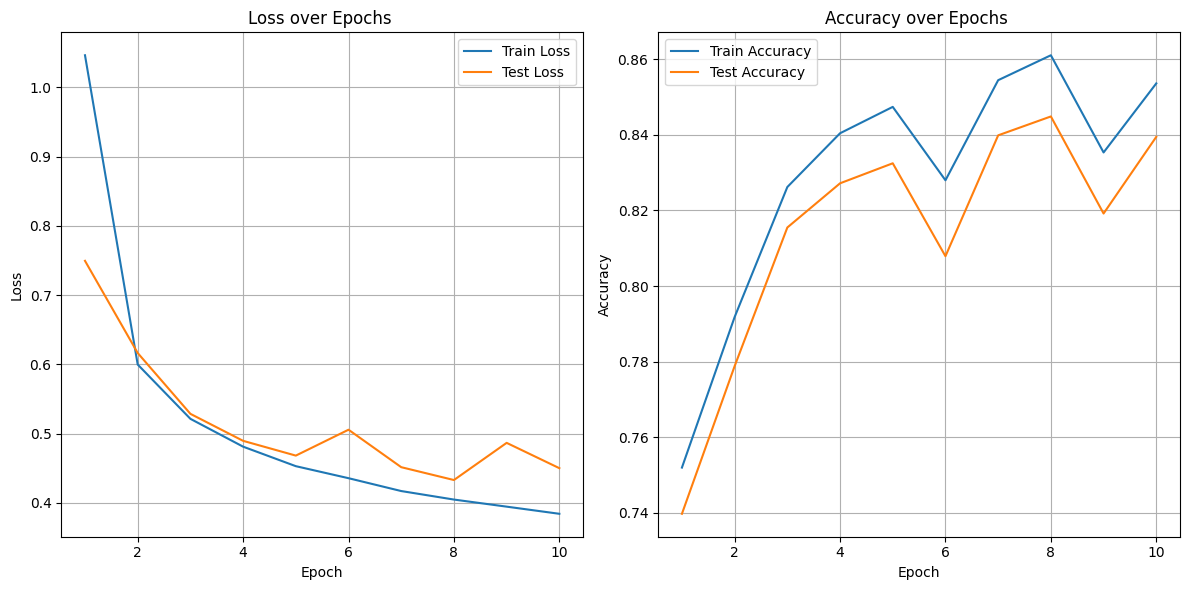

In [ ]:
show_training_graphs(num_epochs, train_losses, test_losses, train_accs, test_accs)

#### Ta khởi tạo giá trị bias khác 0

In [ ]:
b_num           = 0.5

num_epochs, train_losses, test_losses, train_accs, test_accs = train_model(num_inputs, num_hiddens, num_outputs, b_num, learning_rate, sigma,num_epochs)

Epoch 1: train_loss=0.9485, test_loss=0.6688, train_acc=0.7526, test_acc=0.7442
Epoch 2: train_loss=0.5570, test_loss=0.5497, train_acc=0.8067, test_acc=0.7960
Epoch 3: train_loss=0.4927, test_loss=0.4971, train_acc=0.8349, test_acc=0.8225
Epoch 4: train_loss=0.4598, test_loss=0.4833, train_acc=0.8379, test_acc=0.8241
Epoch 5: train_loss=0.4361, test_loss=0.4982, train_acc=0.8283, test_acc=0.8110
Epoch 6: train_loss=0.4183, test_loss=0.4679, train_acc=0.8446, test_acc=0.8284
Epoch 7: train_loss=0.4029, test_loss=0.4491, train_acc=0.8505, test_acc=0.8377
Epoch 8: train_loss=0.3944, test_loss=0.4420, train_acc=0.8561, test_acc=0.8410
Epoch 9: train_loss=0.3818, test_loss=0.4606, train_acc=0.8460, test_acc=0.8334
Epoch 10: train_loss=0.3738, test_loss=0.5093, train_acc=0.8313, test_acc=0.8192


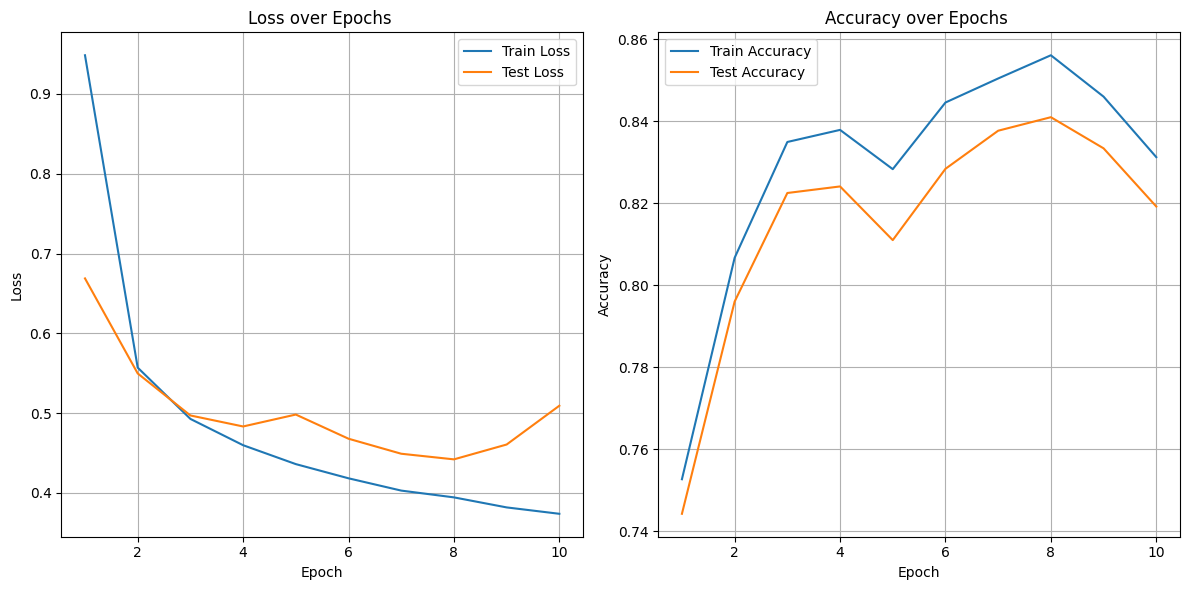

In [ ]:
show_training_graphs(num_epochs, train_losses, test_losses, train_accs, test_accs)

#### Khi b1, b2 được khởi tạo giá trị > 0 thì tính đối xứng ban đầu giảm, độ chính xác cũng giảm theo.

## Exercises

### 1: Change the number of hidden units num_hiddens and plot how its number affects the accuracy of the model. What is the best value of this hyperparameter?



In [ ]:
def gen_logrithm_nums(initial_value = 5, growth_factor = 2, num_elements = 12):
    return [initial_value * growth_factor**i for i in range(num_elements)]


Training with num_hiddens = 64
Epoch 1: train_loss=1.1345, test_loss=0.7942, train_acc=0.6962, test_acc=0.6952
Epoch 2: train_loss=0.6344, test_loss=0.6327, train_acc=0.7911, test_acc=0.7826
Epoch 3: train_loss=0.5387, test_loss=0.5288, train_acc=0.8253, test_acc=0.8128
Epoch 4: train_loss=0.4931, test_loss=0.4976, train_acc=0.8390, test_acc=0.8246
Epoch 5: train_loss=0.4695, test_loss=0.4848, train_acc=0.8418, test_acc=0.8254
Epoch 6: train_loss=0.4465, test_loss=0.4783, train_acc=0.8429, test_acc=0.8300
Epoch 7: train_loss=0.4283, test_loss=0.4564, train_acc=0.8512, test_acc=0.8390
Epoch 8: train_loss=0.4176, test_loss=0.4783, train_acc=0.8426, test_acc=0.8270
Epoch 9: train_loss=0.4088, test_loss=0.4586, train_acc=0.8527, test_acc=0.8357
Epoch 10: train_loss=0.3956, test_loss=0.4640, train_acc=0.8506, test_acc=0.8368


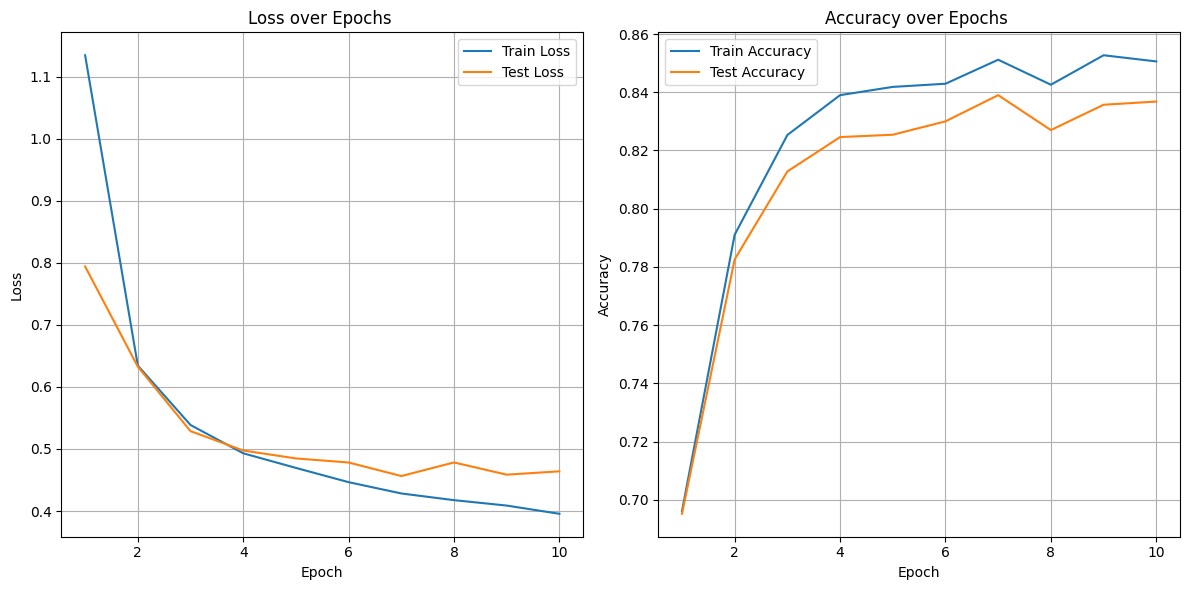

Final Test Accuracy for 64 hidden units: 0.8368

Training with num_hiddens = 128
Epoch 1: train_loss=1.0883, test_loss=0.8825, train_acc=0.6823, test_acc=0.6762
Epoch 2: train_loss=0.6144, test_loss=0.6904, train_acc=0.7407, test_acc=0.7222
Epoch 3: train_loss=0.5297, test_loss=0.6395, train_acc=0.7967, test_acc=0.7846
Epoch 4: train_loss=0.4905, test_loss=0.5302, train_acc=0.8254, test_acc=0.8124
Epoch 5: train_loss=0.4621, test_loss=0.4875, train_acc=0.8420, test_acc=0.8281
Epoch 6: train_loss=0.4414, test_loss=0.4647, train_acc=0.8466, test_acc=0.8329
Epoch 7: train_loss=0.4250, test_loss=0.4912, train_acc=0.8347, test_acc=0.8208
Epoch 8: train_loss=0.4124, test_loss=0.4698, train_acc=0.8494, test_acc=0.8359
Epoch 9: train_loss=0.3989, test_loss=0.5207, train_acc=0.8222, test_acc=0.8060
Epoch 10: train_loss=0.3918, test_loss=0.4226, train_acc=0.8655, test_acc=0.8484


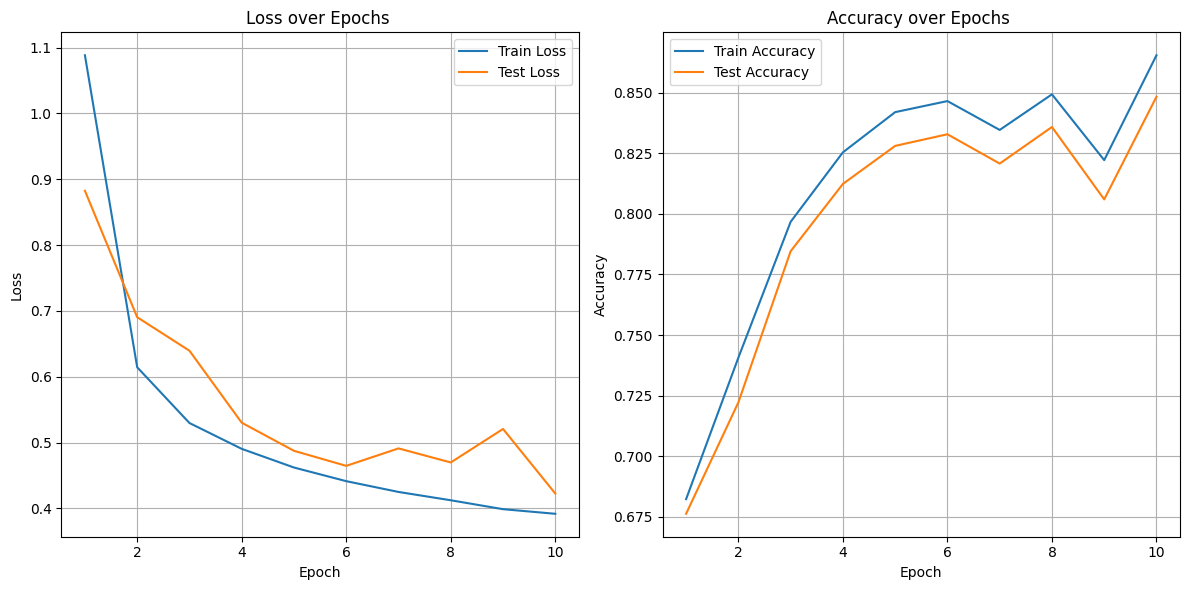

Final Test Accuracy for 128 hidden units: 0.8484

Training with num_hiddens = 256
Epoch 1: train_loss=1.0459, test_loss=0.7131, train_acc=0.7539, test_acc=0.7444
Epoch 2: train_loss=0.5999, test_loss=0.5706, train_acc=0.8096, test_acc=0.7963
Epoch 3: train_loss=0.5173, test_loss=0.5195, train_acc=0.8299, test_acc=0.8188
Epoch 4: train_loss=0.4793, test_loss=0.4917, train_acc=0.8375, test_acc=0.8228
Epoch 5: train_loss=0.4562, test_loss=0.4789, train_acc=0.8435, test_acc=0.8306
Epoch 6: train_loss=0.4323, test_loss=0.4485, train_acc=0.8565, test_acc=0.8395
Epoch 7: train_loss=0.4176, test_loss=0.4867, train_acc=0.8368, test_acc=0.8209
Epoch 8: train_loss=0.4038, test_loss=0.4259, train_acc=0.8643, test_acc=0.8496
Epoch 9: train_loss=0.3928, test_loss=0.4458, train_acc=0.8532, test_acc=0.8348
Epoch 10: train_loss=0.3837, test_loss=0.4417, train_acc=0.8565, test_acc=0.8417


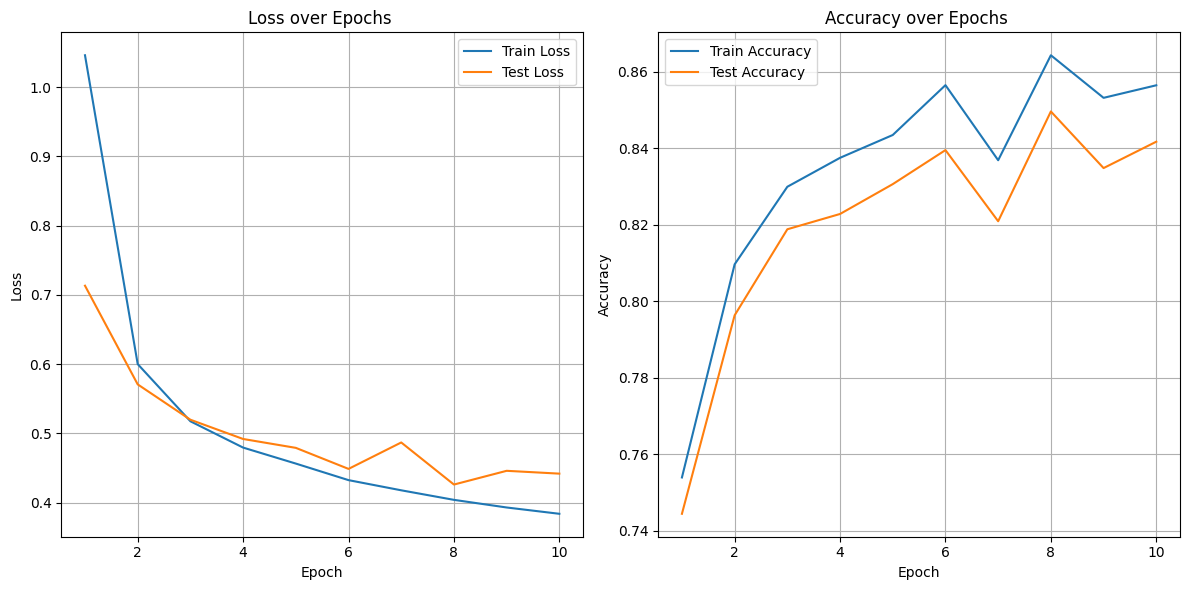

Final Test Accuracy for 256 hidden units: 0.8417

Training with num_hiddens = 512
Epoch 1: train_loss=0.9903, test_loss=0.7165, train_acc=0.7338, test_acc=0.7261
Epoch 2: train_loss=0.5851, test_loss=0.5419, train_acc=0.8254, test_acc=0.8148
Epoch 3: train_loss=0.5103, test_loss=0.5248, train_acc=0.8255, test_acc=0.8138
Epoch 4: train_loss=0.4744, test_loss=0.4790, train_acc=0.8435, test_acc=0.8301
Epoch 5: train_loss=0.4457, test_loss=0.4973, train_acc=0.8376, test_acc=0.8248
Epoch 6: train_loss=0.4266, test_loss=0.4777, train_acc=0.8429, test_acc=0.8254
Epoch 7: train_loss=0.4141, test_loss=0.4377, train_acc=0.8591, test_acc=0.8414
Epoch 8: train_loss=0.3993, test_loss=0.4367, train_acc=0.8592, test_acc=0.8449
Epoch 9: train_loss=0.3893, test_loss=0.4161, train_acc=0.8680, test_acc=0.8502
Epoch 10: train_loss=0.3785, test_loss=0.4417, train_acc=0.8539, test_acc=0.8380


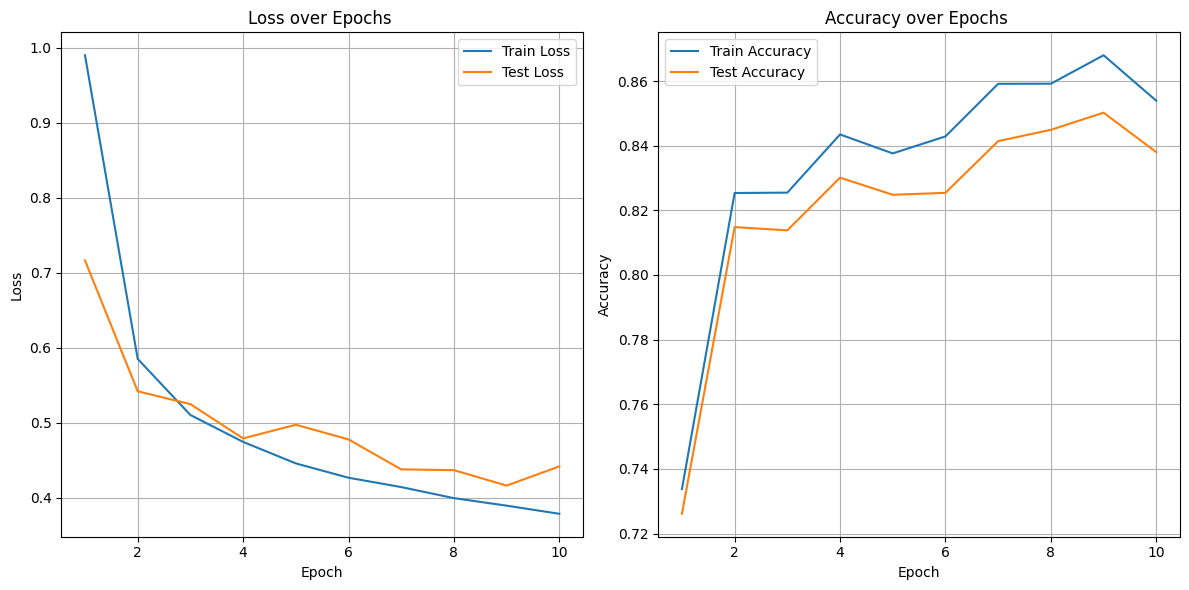

Final Test Accuracy for 512 hidden units: 0.8380

Training with num_hiddens = 1024
Epoch 1: train_loss=0.9420, test_loss=0.6274, train_acc=0.7931, test_acc=0.7832
Epoch 2: train_loss=0.5704, test_loss=0.5471, train_acc=0.8220, test_acc=0.8084
Epoch 3: train_loss=0.5036, test_loss=0.5731, train_acc=0.8178, test_acc=0.8062
Epoch 4: train_loss=0.4683, test_loss=0.5607, train_acc=0.8043, test_acc=0.7936
Epoch 5: train_loss=0.4421, test_loss=0.4583, train_acc=0.8505, test_acc=0.8370
Epoch 6: train_loss=0.4216, test_loss=0.4458, train_acc=0.8576, test_acc=0.8446
Epoch 7: train_loss=0.4067, test_loss=0.4311, train_acc=0.8638, test_acc=0.8485
Epoch 8: train_loss=0.3923, test_loss=0.4276, train_acc=0.8628, test_acc=0.8453
Epoch 9: train_loss=0.3825, test_loss=0.4198, train_acc=0.8672, test_acc=0.8511
Epoch 10: train_loss=0.3751, test_loss=0.4210, train_acc=0.8630, test_acc=0.8457


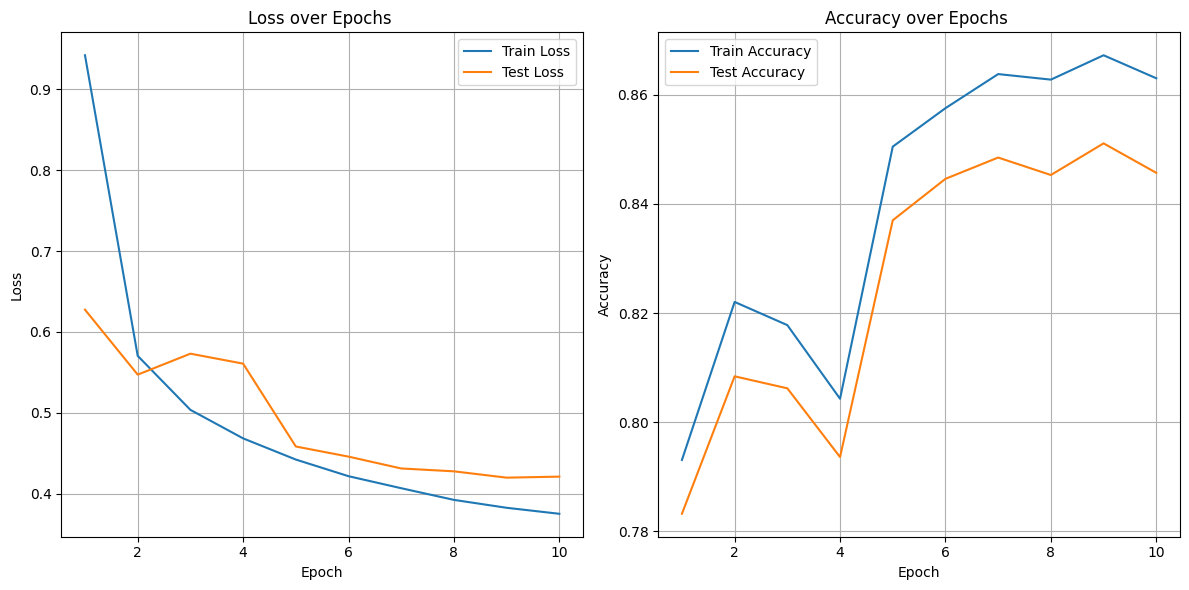

Final Test Accuracy for 1024 hidden units: 0.8457

Training with num_hiddens = 2048
Epoch 1: train_loss=0.8738, test_loss=0.6277, train_acc=0.7883, test_acc=0.7785
Epoch 2: train_loss=0.5565, test_loss=0.6152, train_acc=0.8025, test_acc=0.7925
Epoch 3: train_loss=0.4899, test_loss=0.4886, train_acc=0.8445, test_acc=0.8317
Epoch 4: train_loss=0.4632, test_loss=0.5851, train_acc=0.8194, test_acc=0.8079
Epoch 5: train_loss=0.4333, test_loss=0.4772, train_acc=0.8460, test_acc=0.8347
Epoch 6: train_loss=0.4159, test_loss=0.4314, train_acc=0.8628, test_acc=0.8478
Epoch 7: train_loss=0.3991, test_loss=0.4269, train_acc=0.8625, test_acc=0.8479
Epoch 8: train_loss=0.3885, test_loss=0.4599, train_acc=0.8496, test_acc=0.8346
Epoch 9: train_loss=0.3767, test_loss=0.4097, train_acc=0.8702, test_acc=0.8532
Epoch 10: train_loss=0.3676, test_loss=0.4167, train_acc=0.8661, test_acc=0.8499


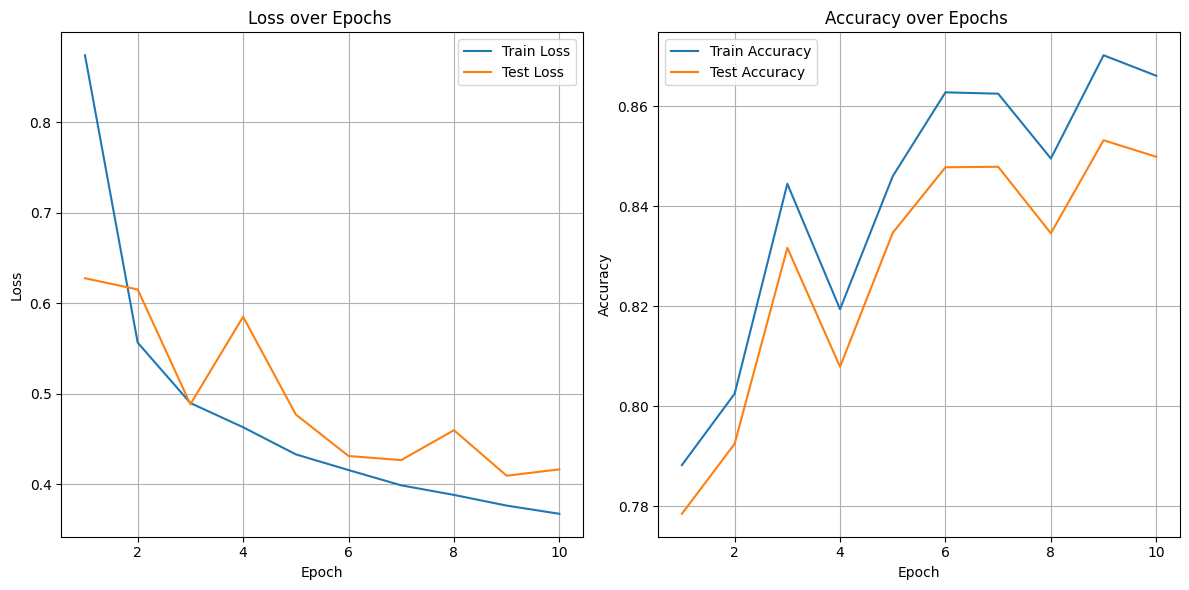

Final Test Accuracy for 2048 hidden units: 0.8499

Training with num_hiddens = 4096
Epoch 1: train_loss=0.8176, test_loss=0.7674, train_acc=0.7471, test_acc=0.7378
Epoch 2: train_loss=0.5381, test_loss=0.5569, train_acc=0.8178, test_acc=0.8074
Epoch 3: train_loss=0.4832, test_loss=0.6043, train_acc=0.7829, test_acc=0.7607
Epoch 4: train_loss=0.4486, test_loss=0.4630, train_acc=0.8510, test_acc=0.8384
Epoch 5: train_loss=0.4258, test_loss=0.5417, train_acc=0.8201, test_acc=0.8084
Epoch 6: train_loss=0.4085, test_loss=0.4347, train_acc=0.8614, test_acc=0.8469
Epoch 7: train_loss=0.3918, test_loss=0.4370, train_acc=0.8575, test_acc=0.8400
Epoch 8: train_loss=0.3804, test_loss=0.4164, train_acc=0.8684, test_acc=0.8485
Epoch 9: train_loss=0.3684, test_loss=0.4122, train_acc=0.8705, test_acc=0.8537
Epoch 10: train_loss=0.3594, test_loss=0.4032, train_acc=0.8735, test_acc=0.8549


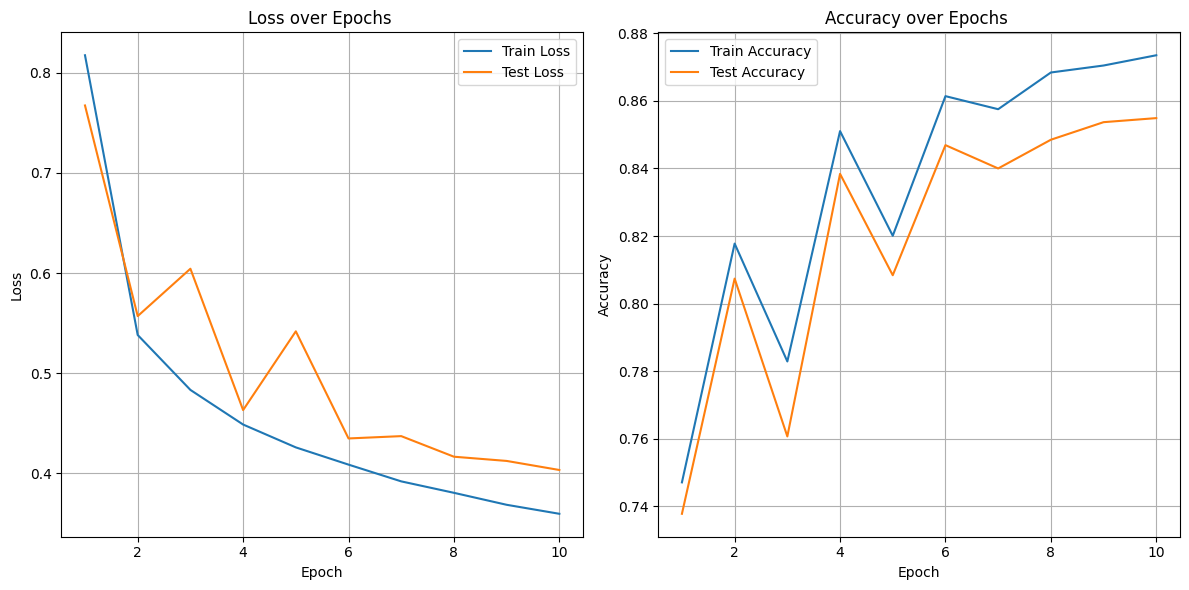

Final Test Accuracy for 4096 hidden units: 0.8549

Training with num_hiddens = 8192
Epoch 1: train_loss=0.7632, test_loss=0.6313, train_acc=0.7871, test_acc=0.7703
Epoch 2: train_loss=0.5201, test_loss=0.5442, train_acc=0.8146, test_acc=0.7984
Epoch 3: train_loss=0.4660, test_loss=0.4797, train_acc=0.8437, test_acc=0.8309
Epoch 4: train_loss=0.4363, test_loss=0.4669, train_acc=0.8479, test_acc=0.8352
Epoch 5: train_loss=0.4102, test_loss=0.4503, train_acc=0.8531, test_acc=0.8373
Epoch 6: train_loss=0.3946, test_loss=0.4162, train_acc=0.8687, test_acc=0.8538
Epoch 7: train_loss=0.3815, test_loss=0.4566, train_acc=0.8564, test_acc=0.8406
Epoch 8: train_loss=0.3689, test_loss=0.4388, train_acc=0.8546, test_acc=0.8385
Epoch 9: train_loss=0.3582, test_loss=0.3992, train_acc=0.8753, test_acc=0.8569
Epoch 10: train_loss=0.3500, test_loss=0.3866, train_acc=0.8819, test_acc=0.8638


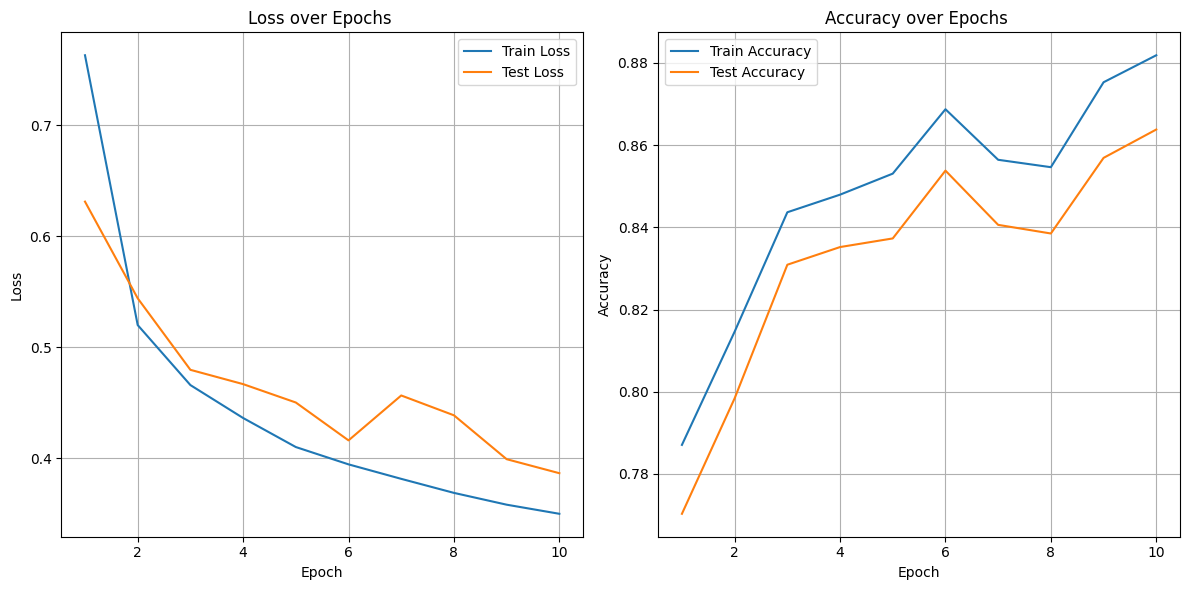

Final Test Accuracy for 8192 hidden units: 0.8638
The Best Test Accuracy for num_hiddens 8192: 0.8638


In [ ]:
num_hiddens = gen_logrithm_nums(initial_value=64, growth_factor=2, num_elements=8)
final_test_accuracies = []
best_accuracy = 0.0
best_num_hiddens = 0
b_num = 0

for num_hidden in num_hiddens:
    print(f"\nTraining with num_hiddens = {num_hidden}")
    num_epochs, train_losses, test_losses, train_accs, test_accs = train_model(num_inputs, num_hidden, num_outputs, b_num, learning_rate, sigma)
    show_training_graphs(num_epochs, train_losses, test_losses, train_accs, test_accs)
    final_test_accuracies.append(test_accs[-1])
    print(f"Final Test Accuracy for {num_hidden} hidden units: {test_accs[-1]:.4f}")
    if test_accs[-1] > best_accuracy:
        best_accuracy = test_accs[-1]
        best_num_hiddens = num_hidden
print(f"The Best Test Accuracy for num_hiddens {best_num_hiddens}: {best_accuracy:.4f}")

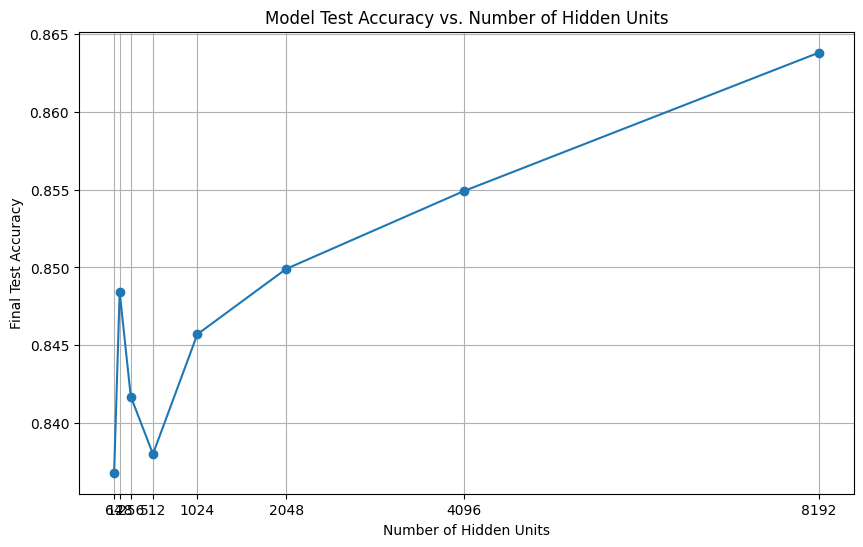

In [ ]:
# Vẽ đồ thị
plt.figure(figsize=(10, 6))
plt.plot(num_hiddens, final_test_accuracies, marker='o', linestyle='-')
plt.title('Model Test Accuracy vs. Number of Hidden Units')
plt.xlabel('Number of Hidden Units')
plt.ylabel('Final Test Accuracy')
plt.xticks(num_hiddens)
plt.grid(True)

*   Thay đổi số neuron trong một lớp ẩn có thể cho độ chính xác tốt hơn, nhưng
tốn tài nguyên nếu số nueron tăng

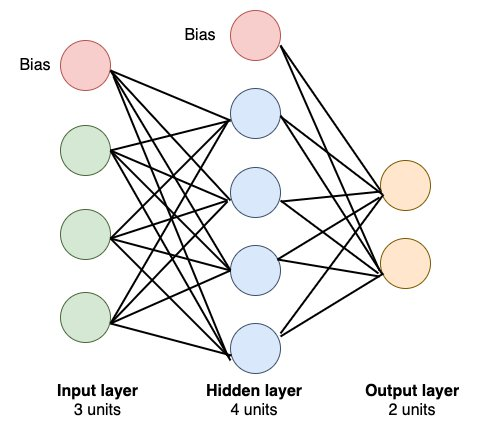

Ta có công thức tính số lượng parameter n lớp ẩn:
$$Parameters=i * h1 + \sum_{k=1}^{n-1}(h_k * h_{k+1}) + h_n * o + \sum_{k=1}^n h_k + o$$
$i$ = số lượng neurons lớp đầu vào \
$h$ = số lượng neurons lớp ẩn \
$o$ = số lượng neurons lớp đầu ra

Công thức tính số lượng parameter 1 lớp ẩn:
$$Parameters=(i * h) + h + (h * o) + o$$
Khi $h$ tăng, số lượng parameter tăng tuyến tính với $h$, dẫn đến khả năng biểu diễn phức tạp hơn (do kích thước tập huấn luyện và độ phức tạp của dữ liệu tăng) cũng như tốn tài nguyên hơn.

### 2: Try adding a hidden layer to see how it affects the results.

In [ ]:
def init_params_n_hidden_layer(layer_dims, sigma=0.01):
    params = {}
    L = len(layer_dims) - 1 # Tổng số lớp có trọng số (hidden + output)

    for l in range(1, L + 1):
        params['W' + str(l)] = np.random.randn(layer_dims[l-1], layer_dims[l]) * sigma
        params['b' + str(l)] = np.zeros((1, layer_dims[l]))
    return params

In [ ]:
def forward_propagation_n_hidden_layer(X, params, num_total_layers):
    cache_A = {0: X} # A0 là X
    cache_Z = {}
    A_curr = X

    # Lớp ẩn (ReLU)
    for l in range(1, num_total_layers): # l từ 1 đến L-1
        Wl = params['W' + str(l)]
        bl = params['b' + str(l)]
        Zl = A_curr.dot(Wl) + bl
        A_curr = relu(Zl)
        cache_Z[l] = Zl
        cache_A[l] = A_curr

    # Lớp đầu ra (Softmax) - lớp L
    WL = params['W' + str(num_total_layers)]
    bL = params['b' + str(num_total_layers)]
    ZL = A_curr.dot(WL) + bL
    Y_hat = softmax(ZL)
    cache_Z[num_total_layers] = ZL
    cache_A[num_total_layers] = Y_hat # AL là Y_hat

    return Y_hat, (cache_A, cache_Z)

In [ ]:
def backward_propagation_n_hidden_layers(X, Y, Y_hat, cache, params, num_total_layers):
    cache_A, cache_Z = cache
    grads = {}
    dZ_curr = gradient_cross_entropy_loss(Y_hat, Y) # dZL là gradient của loss w.r.t Z của lớp output

    for l_idx in range(num_total_layers, 0, -1): # L, L-1, ..., 1
        A_prev = cache_A[l_idx-1] # Activation ở lớp ẩn phía trước (A0 là X ở l_idx=1)
        Wl = params['W' + str(l_idx)]

        # Gradients cho Wl and bl
        grads['dW' + str(l_idx)] = A_prev.T.dot(dZ_curr)
        grads['db' + str(l_idx)] = np.sum(dZ_curr, axis=0, keepdims=True)

        # Tính dZ cho lớp ẩn phía trước, nếu không phải là lớp đầu vào
        if l_idx > 1:
            dA_prev = dZ_curr.dot(Wl.T) # Gradient w.r.t. activation of previous layer (A_{l-1})
            Z_prev = cache_Z[l_idx-1]   # Z value of the previous layer (Z_{l-1})
            dZ_curr = dA_prev * relu_derivative(Z_prev) # Gradient w.r.t. Z of previous layer

    return grads

def update_params_n_hidden_layers(params, grads, learning_rate, num_total_layers):
    for l in range(1, num_total_layers + 1):
        params['W' + str(l)] -= learning_rate * grads['dW' + str(l)]
        params['b' + str(l)] -= learning_rate * grads['db' + str(l)]

In [ ]:
def evaluate_accuracy_n_hidden_layers(data_loader, params, layer_dims):
    correct = total = 0
    num_total_layers = len(layer_dims) - 1
    num_inputs = layer_dims[0]
    for X_t, y_t in data_loader:
        X_t = X_t.to(device)
        y_t = y_t.to(device)
        X_np = X_t.cpu().numpy().reshape(-1, num_inputs)
        y_np = y_t.cpu().numpy()

        Y_hat, _ = forward_propagation_n_hidden_layer(X_np, params, num_total_layers)
        y_pred = np.argmax(Y_hat, axis=1)
        correct += np.sum(y_pred == y_np)
        total += y_t.shape[0]
    return correct / total

def evaluate_loss_n_hidden_layers(data_loader, params, layer_dims):
    total_loss = 0.0
    total_samples = 0
    num_total_layers = len(layer_dims) - 1
    num_inputs = layer_dims[0]
    for X_t, y_t in data_loader:
        X_t = X_t.to(device)
        y_t = y_t.to(device)
        X_np = X_t.cpu().numpy().reshape(-1, num_inputs)
        y_np = y_t.cpu().numpy()

        Y_hat, _ = forward_propagation_n_hidden_layer(X_np, params, num_total_layers)
        loss = cross_entropy_loss(Y_hat, y_np)
        total_loss += loss * X_np.shape[0]
        total_samples += X_np.shape[0]
    return total_loss / total_samples

In [ ]:
def train_model_n_hidden_layers(layer_dims, learning_rate=0.1, sigma=0.01, num_epochs=10):
    params = init_params_n_hidden_layer(layer_dims, sigma)
    num_total_layers = len(layer_dims) - 1
    num_inputs = layer_dims[0]

    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []

    print(f"Starting training with architecture: {layer_dims}")
    for epoch in range(1, num_epochs + 1):
        epoch_train_loss = 0.0
        for X_batch_t, y_batch_t in train_loader:
            # Chuyển sang numpy
            X_batch_t = X_batch_t.to(device)
            y_batch_t = y_batch_t.to(device)
            X_batch_np = X_batch_t.cpu().numpy().reshape(-1, num_inputs)
            y_batch_np = y_batch_t.cpu().numpy()

            # Forward propagation
            Y_hat, cache = forward_propagation_n_hidden_layer(X_batch_np, params, num_total_layers)

            # Tính loss (dZ cho output layer thì cũng được tiinhs trong cross_entropy_loss)
            current_loss = cross_entropy_loss(Y_hat, y_batch_np)
            epoch_train_loss += current_loss * X_batch_np.shape[0]

            # Backward propagation
            grads = backward_propagation_n_hidden_layers(X_batch_np, y_batch_np, Y_hat, cache, params, num_total_layers)

            # Cập nhật parameters
            update_params_n_hidden_layers(params, grads, learning_rate, num_total_layers)

        # Evaluate and store metrics for the epoch
        avg_epoch_train_loss = epoch_train_loss / len(train_ds)
        train_losses.append(avg_epoch_train_loss)

        current_test_loss = evaluate_loss_n_hidden_layers(test_loader, params, layer_dims)
        test_losses.append(current_test_loss)

        current_train_acc = evaluate_accuracy_n_hidden_layers(train_loader, params, layer_dims)
        train_accs.append(current_train_acc)

        current_test_acc = evaluate_accuracy_n_hidden_layers(test_loader, params, layer_dims)
        test_accs.append(current_test_acc)

        print(f"Epoch {epoch}/{num_epochs}: "
              f"train_loss={avg_epoch_train_loss:.4f}, "
              f"test_loss={current_test_loss:.4f}, "
              f"train_acc={current_train_acc:.4f}, "
              f"test_acc={current_test_acc:.4f}")

    return num_epochs, train_losses, test_losses, train_accs, test_accs, params

*   Implement MLP với 2 lớp ẩn


In [ ]:
layer_dimensions  = [784, 256, 128, 10]
trained_epochs, t_losses, v_losses, t_accs, v_accs, trained_params = train_model_n_hidden_layers(
        layer_dims=layer_dimensions,
        learning_rate=learning_rate,
        sigma=sigma,
        num_epochs=num_epochs
    )

Starting training with architecture: [784, 256, 128, 10]
Epoch 1/10: train_loss=1.8136, test_loss=1.1602, train_acc=0.5488, test_acc=0.5420
Epoch 2/10: train_loss=0.9086, test_loss=0.8539, train_acc=0.6910, test_acc=0.6830
Epoch 3/10: train_loss=0.7014, test_loss=0.6460, train_acc=0.7772, test_acc=0.7634
Epoch 4/10: train_loss=0.5953, test_loss=0.5647, train_acc=0.8098, test_acc=0.8002
Epoch 5/10: train_loss=0.5392, test_loss=0.5329, train_acc=0.8251, test_acc=0.8118
Epoch 6/10: train_loss=0.4947, test_loss=0.5520, train_acc=0.8009, test_acc=0.7952
Epoch 7/10: train_loss=0.4598, test_loss=0.4828, train_acc=0.8387, test_acc=0.8226
Epoch 8/10: train_loss=0.4341, test_loss=0.4705, train_acc=0.8471, test_acc=0.8358
Epoch 9/10: train_loss=0.4160, test_loss=0.4352, train_acc=0.8588, test_acc=0.8434
Epoch 10/10: train_loss=0.3971, test_loss=0.4271, train_acc=0.8609, test_acc=0.8465


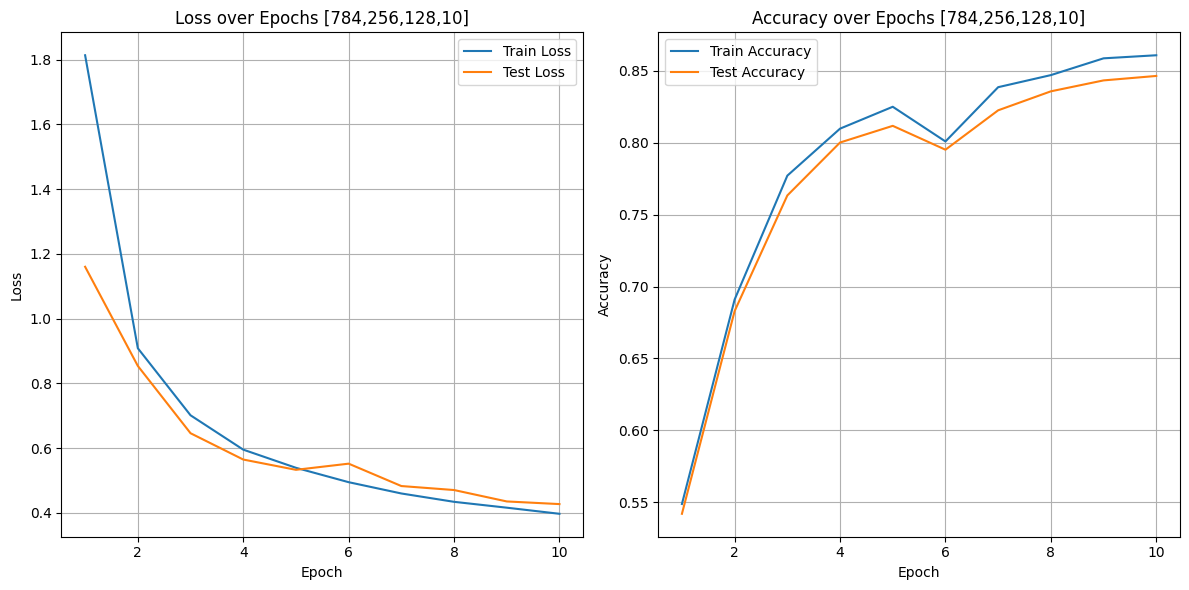

In [ ]:
layer_dims_for_plot = str(layer_dimensions).replace(" ","")
show_training_graphs(trained_epochs, t_losses, v_losses, t_accs, v_accs, layer_dims_str=layer_dims_for_plot)

*   Implement với 3 lớp ẩn

In [ ]:
layer_dimensions  = [784, 256, 128, 64, 10]
trained_epochs, t_losses, v_losses, t_accs, v_accs, trained_params = train_model_n_hidden_layers(
        layer_dims=layer_dimensions,
        learning_rate=learning_rate,
        sigma=sigma,
        num_epochs=num_epochs
    )

Starting training with architecture: [784, 256, 128, 64, 10]
Epoch 1/10: train_loss=2.3027, test_loss=2.3025, train_acc=0.1000, test_acc=0.1000
Epoch 2/10: train_loss=2.3025, test_loss=2.3022, train_acc=0.1000, test_acc=0.1000
Epoch 3/10: train_loss=2.3002, test_loss=2.2899, train_acc=0.2547, test_acc=0.2548
Epoch 4/10: train_loss=1.7637, test_loss=1.3521, train_acc=0.3798, test_acc=0.3782
Epoch 5/10: train_loss=1.2729, test_loss=1.0967, train_acc=0.5498, test_acc=0.5486
Epoch 6/10: train_loss=1.0261, test_loss=1.0586, train_acc=0.6126, test_acc=0.6063
Epoch 7/10: train_loss=0.8381, test_loss=0.7421, train_acc=0.7177, test_acc=0.7147
Epoch 8/10: train_loss=0.7059, test_loss=0.6547, train_acc=0.7688, test_acc=0.7607
Epoch 9/10: train_loss=0.6182, test_loss=0.6125, train_acc=0.7875, test_acc=0.7740
Epoch 10/10: train_loss=0.5578, test_loss=0.6294, train_acc=0.7884, test_acc=0.7804


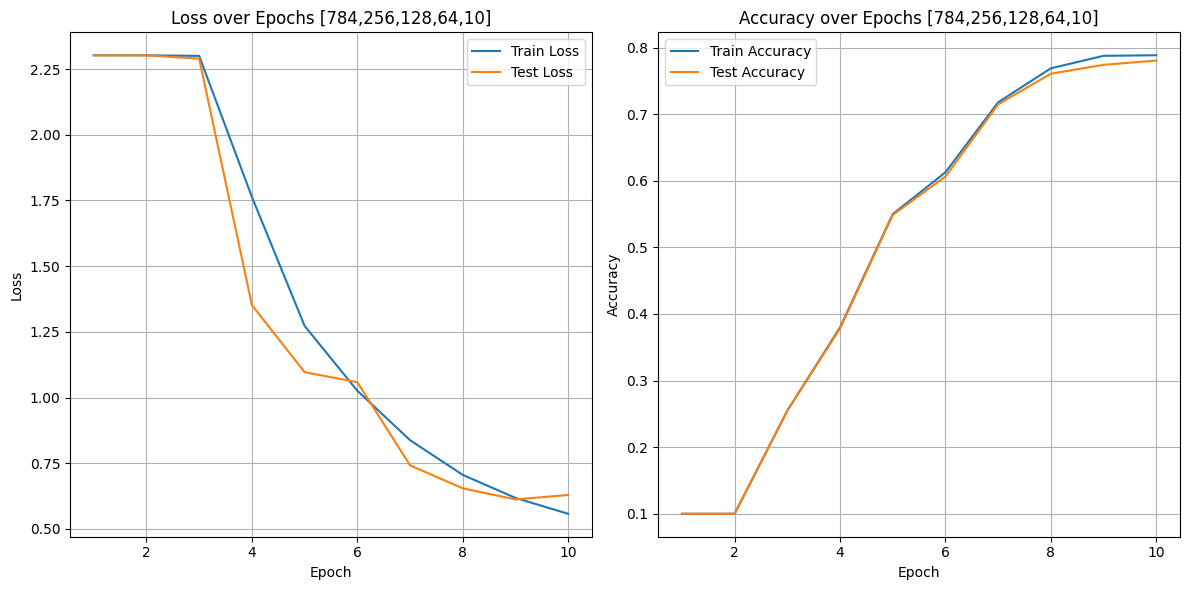

In [ ]:
layer_dims_for_plot = str(layer_dimensions).replace(" ","")
show_training_graphs(trained_epochs, t_losses, v_losses, t_accs, v_accs, layer_dims_str=layer_dims_for_plot)

*   Implement với 4 lớp ẩn

In [ ]:
layer_dimensions  = [784, 512, 256, 128, 64, 10]
trained_epochs, t_losses, v_losses, t_accs, v_accs, trained_params = train_model_n_hidden_layers(
        layer_dims=layer_dimensions,
        learning_rate=learning_rate,
        sigma=sigma,
        num_epochs=num_epochs
    )

Starting training with architecture: [784, 512, 256, 128, 64, 10]
Epoch 1/10: train_loss=2.3027, test_loss=2.3026, train_acc=0.1000, test_acc=0.1000
Epoch 2/10: train_loss=2.3027, test_loss=2.3026, train_acc=0.1000, test_acc=0.1000
Epoch 3/10: train_loss=2.3027, test_loss=2.3026, train_acc=0.1000, test_acc=0.1000
Epoch 4/10: train_loss=2.3027, test_loss=2.3026, train_acc=0.1000, test_acc=0.1000
Epoch 5/10: train_loss=2.3027, test_loss=2.3026, train_acc=0.1000, test_acc=0.1000
Epoch 6/10: train_loss=2.3027, test_loss=2.3026, train_acc=0.1000, test_acc=0.1000
Epoch 7/10: train_loss=2.3027, test_loss=2.3026, train_acc=0.1547, test_acc=0.1522
Epoch 8/10: train_loss=2.3027, test_loss=2.3025, train_acc=0.1000, test_acc=0.1000
Epoch 9/10: train_loss=2.3026, test_loss=2.3025, train_acc=0.1000, test_acc=0.1000
Epoch 10/10: train_loss=2.3025, test_loss=2.3024, train_acc=0.1090, test_acc=0.1095


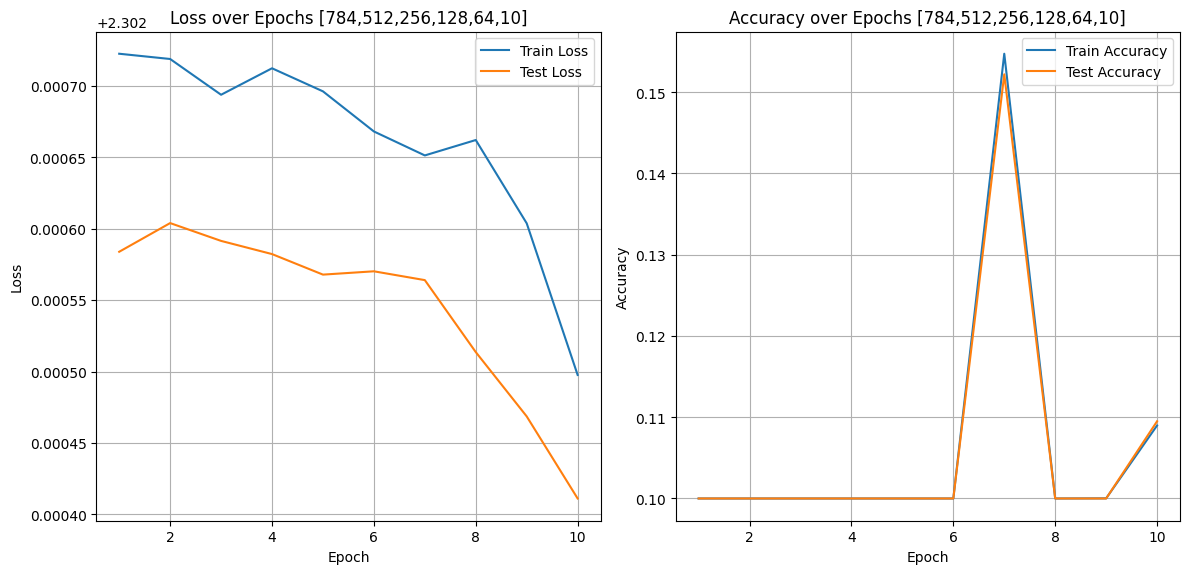

In [ ]:
layer_dims_for_plot = str(layer_dimensions).replace(" ","")
show_training_graphs(trained_epochs, t_losses, v_losses, t_accs, v_accs, layer_dims_str=layer_dims_for_plot)

* Tăng số lớp ẩn có thể cho độ chính xác tốt hơn. Nhưng tăng quá nhiều lớp dễ đẫn đến overfitting và tốn tài nguyên.

### 3: Why is it a bad idea to insert a hidden layer with a single neuron? What could go wrong?
Việc thêm một lớp ẩn chỉ với một neuron duy nhất vào một MLP thường là một ý tưởng không tốt vì nó tạo ra một "Bottleneck" nghiêm trọng về thông tin và hạn chế đáng kể khả năng biểu diễn của mạng. Lớp này sẽ nén toàn bộ thông tin đầu vào thành một giá trị duy nhất, khiến mạng không thể học được các đặc trưng phức tạp trong dữ liệu. \
Trong một MLP, các lớp ẩn được thiết kế để học các biểu diễn trung gian, phi tuyến của dữ liệu đầu vào. Các neuron trong lớp ẩn kết hợp các tín hiệu từ lớp trước đó và áp dụng một hàm kích hoạt (thường là phi tuyến như ReLU, sigmoid, tanh) để tạo ra các đặc trưng mới. Những đặc trưng này sau đó được sử dụng bởi các lớp tiếp theo để thực hiện nhiệm vụ (ví dụ: phân loại hoặc hồi quy). Số lượng neuron trong một lớp ẩn thường liên quan đến độ phức tạp của các hàm mà mạng có thể học
*   Giảm chiều dữ liệu xuống 1: \
Một lớp ẩn với 1 neuron sẽ biến mọi đầu vào (dù có nhiều chiều) thành một số duy nhất. Như vậy, mọi thông tin phân biệt giữa các điểm dữ liệu chỉ còn lại trên một trục số, khiến mạng chỉ có thể học các ranh giới quyết định tuyến tính (một đường thẳng trên trục số).
*   Không đủ khả năng phân biệt: \
Nếu đầu vào phức tạp, ví dụ như hình ảnh hoặc dữ liệu nhiều chiều, việc nén toàn bộ xuống 1 chiều sẽ làm mất mát thông tin quan trọng. Mạng sẽ không thể phân biệt được các mẫu dữ liệu có đặc trưng khác nhau nhưng lại có cùng giá trị sau khi qua lớp 1 neuron này.
*   Giới hạn khả năng mô hình hóa: \
Mỗi neuron trong lớp ẩn giống như một bộ lọc đặc trưng. Nếu chỉ có 1 neuron, mạng chỉ học được một đặc trưng duy nhất. Để mô hình hóa các quan hệ phi tuyến tính phức tạp, cần nhiều neuron để tạo ra nhiều đặc trưng khác nhau




*   Implement 1 lớp ẩn với 1 neron

In [ ]:
layer_dimensions  = [784, 1, 10]
# num_epochs        = 20
trained_epochs, t_losses, v_losses, t_accs, v_accs, trained_params = train_model_n_hidden_layers(
        layer_dims=layer_dimensions,
        learning_rate=learning_rate,
        sigma=sigma,
        num_epochs=num_epochs
    )

Starting training with architecture: [784, 1, 10]
Epoch 1/10: train_loss=2.0206, test_loss=1.8367, train_acc=0.2768, test_acc=0.2765
Epoch 2/10: train_loss=1.7114, test_loss=1.6538, train_acc=0.3406, test_acc=0.3366
Epoch 3/10: train_loss=1.6097, test_loss=1.5766, train_acc=0.3540, test_acc=0.3585
Epoch 4/10: train_loss=1.5534, test_loss=1.5530, train_acc=0.3352, test_acc=0.3348
Epoch 5/10: train_loss=1.5217, test_loss=1.5032, train_acc=0.3681, test_acc=0.3682
Epoch 6/10: train_loss=1.4992, test_loss=1.5200, train_acc=0.3224, test_acc=0.3181
Epoch 7/10: train_loss=1.4766, test_loss=1.4801, train_acc=0.3530, test_acc=0.3523
Epoch 8/10: train_loss=1.4612, test_loss=1.4489, train_acc=0.3650, test_acc=0.3615
Epoch 9/10: train_loss=1.4476, test_loss=1.4836, train_acc=0.3461, test_acc=0.3420
Epoch 10/10: train_loss=1.4343, test_loss=1.4413, train_acc=0.3651, test_acc=0.3619


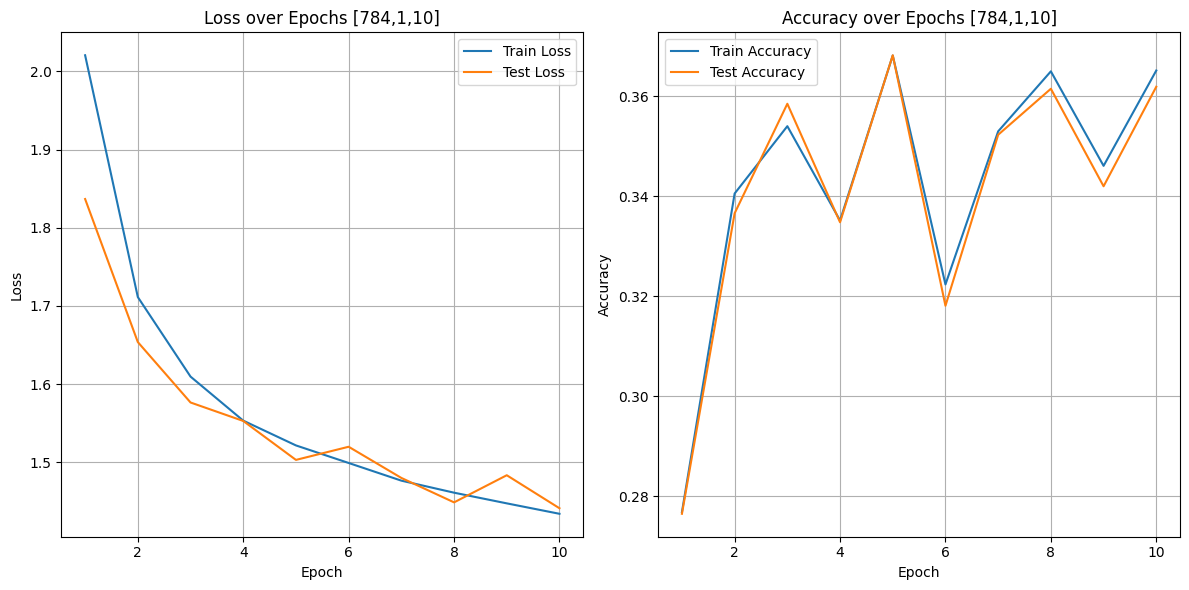

In [ ]:
layer_dims_for_plot = str(layer_dimensions).replace(" ","")
show_training_graphs(trained_epochs, t_losses, v_losses, t_accs, v_accs, layer_dims_str=layer_dims_for_plot)

### 4: How does changing the learning rate alter your results? With all other parameters fixed, which learning rate gives you the best results? How does this relate to the number of epochs?


Training with learning_rate = 0.001
Starting training with architecture: [784, 256, 10]
Epoch 1/10: train_loss=2.2938, test_loss=2.2857, train_acc=0.1686, test_acc=0.1623
Epoch 2/10: train_loss=2.2765, test_loss=2.2669, train_acc=0.2051, test_acc=0.2010
Epoch 3/10: train_loss=2.2553, test_loss=2.2431, train_acc=0.2177, test_acc=0.2142
Epoch 4/10: train_loss=2.2281, test_loss=2.2124, train_acc=0.2362, test_acc=0.2344
Epoch 5/10: train_loss=2.1933, test_loss=2.1733, train_acc=0.2509, test_acc=0.2505
Epoch 6/10: train_loss=2.1492, test_loss=2.1244, train_acc=0.2816, test_acc=0.2777
Epoch 7/10: train_loss=2.0948, test_loss=2.0648, train_acc=0.3403, test_acc=0.3321
Epoch 8/10: train_loss=2.0297, test_loss=1.9949, train_acc=0.4381, test_acc=0.4284
Epoch 9/10: train_loss=1.9553, test_loss=1.9172, train_acc=0.4972, test_acc=0.4875
Epoch 10/10: train_loss=1.8749, test_loss=1.8357, train_acc=0.5413, test_acc=0.5294


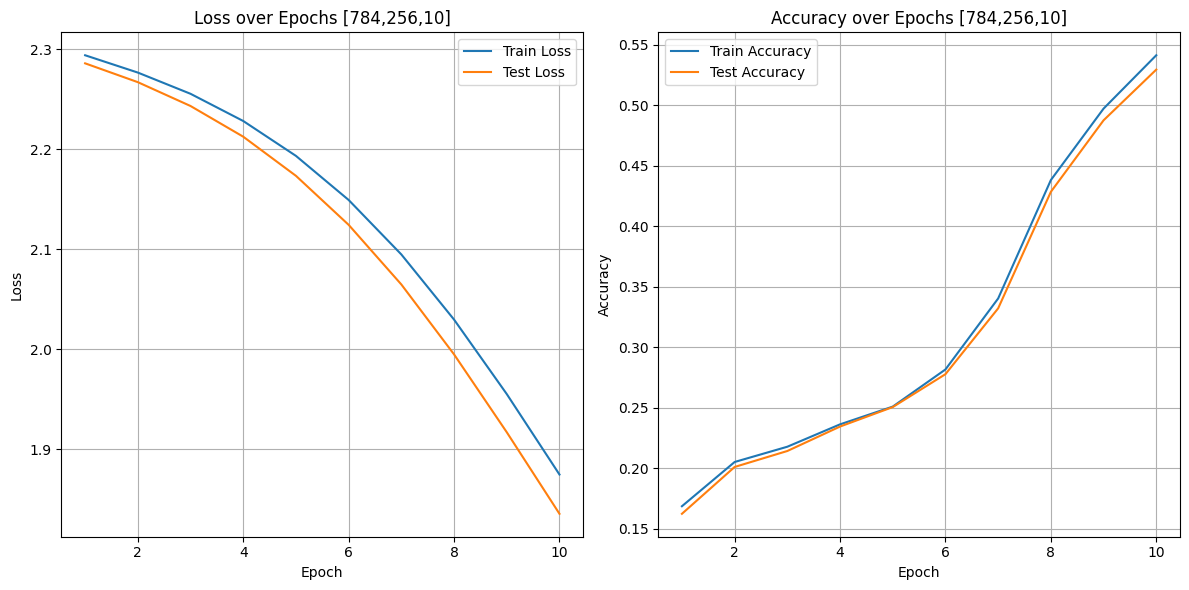

Final Test Accuracy for learning_rate 0.001: 0.5294

Training with learning_rate = 0.01
Starting training with architecture: [784, 256, 10]
Epoch 1/10: train_loss=2.1480, test_loss=1.8605, train_acc=0.4491, test_acc=0.4438
Epoch 2/10: train_loss=1.5214, test_loss=1.2676, train_acc=0.6352, test_acc=0.6284
Epoch 3/10: train_loss=1.1140, test_loss=1.0098, train_acc=0.6528, test_acc=0.6422
Epoch 4/10: train_loss=0.9305, test_loss=0.8873, train_acc=0.6827, test_acc=0.6711
Epoch 5/10: train_loss=0.8363, test_loss=0.8184, train_acc=0.6959, test_acc=0.6814
Epoch 6/10: train_loss=0.7782, test_loss=0.7715, train_acc=0.7231, test_acc=0.7106
Epoch 7/10: train_loss=0.7359, test_loss=0.7345, train_acc=0.7425, test_acc=0.7316
Epoch 8/10: train_loss=0.7014, test_loss=0.7052, train_acc=0.7548, test_acc=0.7410
Epoch 9/10: train_loss=0.6717, test_loss=0.6760, train_acc=0.7710, test_acc=0.7623
Epoch 10/10: train_loss=0.6460, test_loss=0.6551, train_acc=0.7819, test_acc=0.7721


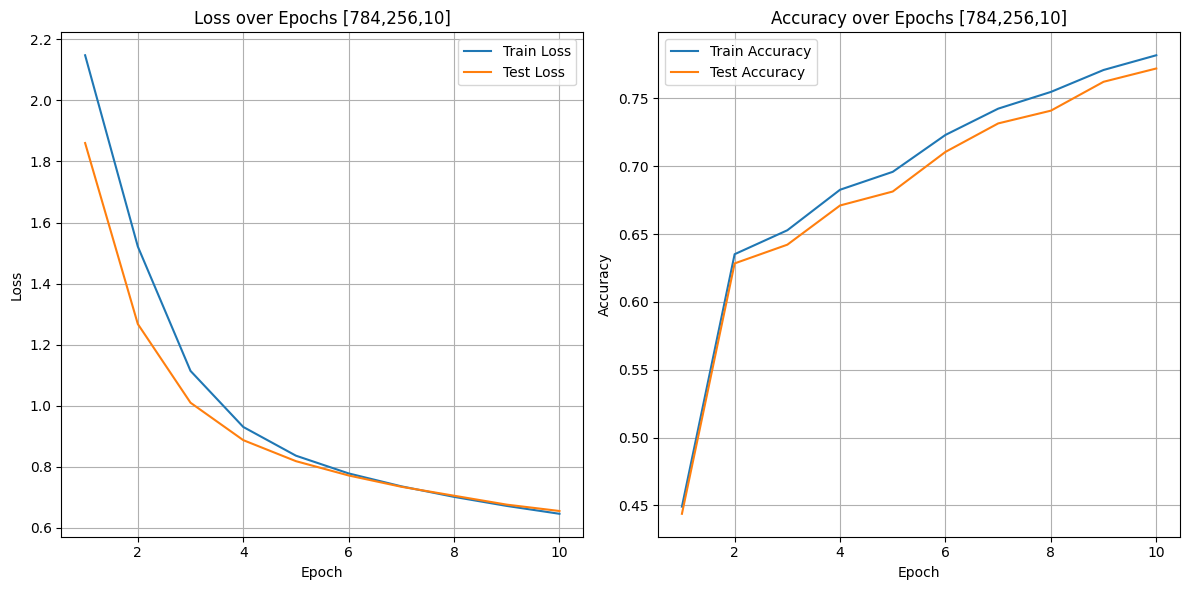

Final Test Accuracy for learning_rate 0.01: 0.7721

Training with learning_rate = 0.1
Starting training with architecture: [784, 256, 10]
Epoch 1/10: train_loss=1.0443, test_loss=0.7329, train_acc=0.7362, test_acc=0.7286
Epoch 2/10: train_loss=0.6029, test_loss=0.6398, train_acc=0.7821, test_acc=0.7671
Epoch 3/10: train_loss=0.5200, test_loss=0.5734, train_acc=0.8089, test_acc=0.7956
Epoch 4/10: train_loss=0.4826, test_loss=0.5137, train_acc=0.8303, test_acc=0.8222
Epoch 5/10: train_loss=0.4539, test_loss=0.5275, train_acc=0.8305, test_acc=0.8171
Epoch 6/10: train_loss=0.4347, test_loss=0.4712, train_acc=0.8456, test_acc=0.8312
Epoch 7/10: train_loss=0.4201, test_loss=0.4591, train_acc=0.8483, test_acc=0.8310
Epoch 8/10: train_loss=0.4053, test_loss=0.4713, train_acc=0.8461, test_acc=0.8315
Epoch 9/10: train_loss=0.3945, test_loss=0.4228, train_acc=0.8644, test_acc=0.8441
Epoch 10/10: train_loss=0.3824, test_loss=0.4270, train_acc=0.8621, test_acc=0.8462


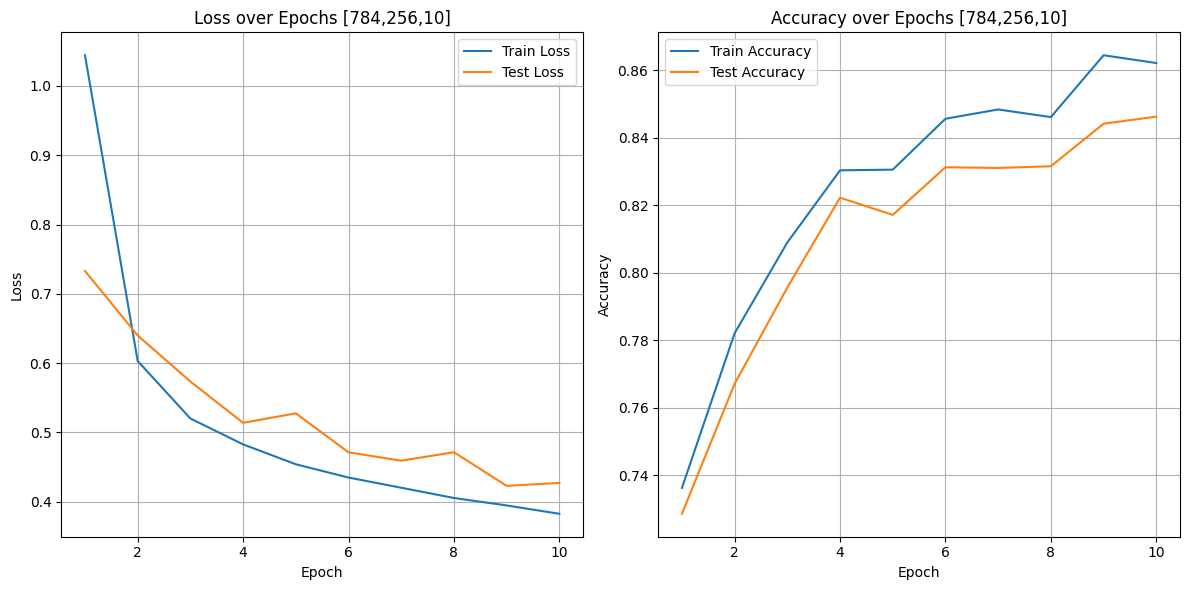

Final Test Accuracy for learning_rate 0.1: 0.8462

Training with learning_rate = 0.3
Starting training with architecture: [784, 256, 10]
Epoch 1/10: train_loss=0.7996, test_loss=0.6212, train_acc=0.7742, test_acc=0.7624
Epoch 2/10: train_loss=0.4932, test_loss=0.5438, train_acc=0.8068, test_acc=0.7966
Epoch 3/10: train_loss=0.4345, test_loss=0.8492, train_acc=0.7155, test_acc=0.7035
Epoch 4/10: train_loss=0.3995, test_loss=0.4071, train_acc=0.8690, test_acc=0.8542
Epoch 5/10: train_loss=0.3777, test_loss=0.4613, train_acc=0.8497, test_acc=0.8334
Epoch 6/10: train_loss=0.3605, test_loss=0.3998, train_acc=0.8725, test_acc=0.8559
Epoch 7/10: train_loss=0.3443, test_loss=0.4624, train_acc=0.8557, test_acc=0.8381
Epoch 8/10: train_loss=0.3338, test_loss=0.4081, train_acc=0.8679, test_acc=0.8482
Epoch 9/10: train_loss=0.3226, test_loss=0.4019, train_acc=0.8767, test_acc=0.8575
Epoch 10/10: train_loss=0.3162, test_loss=0.3836, train_acc=0.8781, test_acc=0.8579


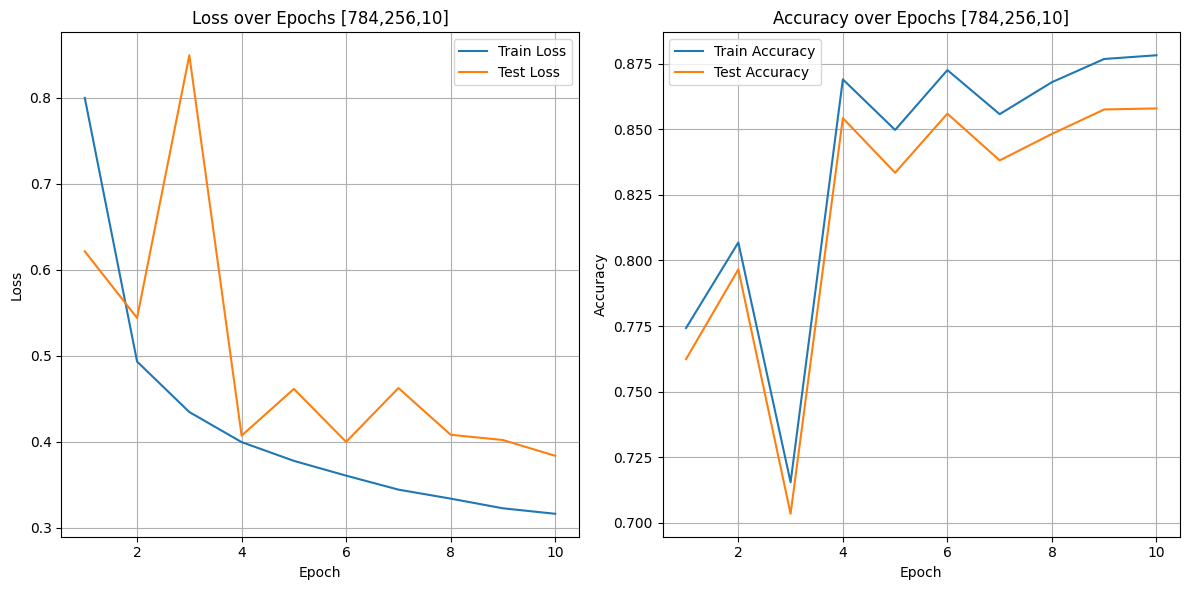

Final Test Accuracy for learning_rate 0.3: 0.8579

Training with learning_rate = 0.5
Starting training with architecture: [784, 256, 10]
Epoch 1/10: train_loss=0.7860, test_loss=0.5995, train_acc=0.7813, test_acc=0.7667
Epoch 2/10: train_loss=0.4913, test_loss=0.5039, train_acc=0.8226, test_acc=0.8085
Epoch 3/10: train_loss=0.4204, test_loss=0.4604, train_acc=0.8430, test_acc=0.8283
Epoch 4/10: train_loss=0.3853, test_loss=0.4232, train_acc=0.8607, test_acc=0.8448
Epoch 5/10: train_loss=0.3653, test_loss=0.4235, train_acc=0.8642, test_acc=0.8483
Epoch 6/10: train_loss=0.3461, test_loss=0.3909, train_acc=0.8775, test_acc=0.8616
Epoch 7/10: train_loss=0.3352, test_loss=0.4662, train_acc=0.8534, test_acc=0.8363
Epoch 8/10: train_loss=0.3240, test_loss=0.3840, train_acc=0.8816, test_acc=0.8591
Epoch 9/10: train_loss=0.3109, test_loss=0.3617, train_acc=0.8902, test_acc=0.8714
Epoch 10/10: train_loss=0.2987, test_loss=0.4297, train_acc=0.8693, test_acc=0.8481


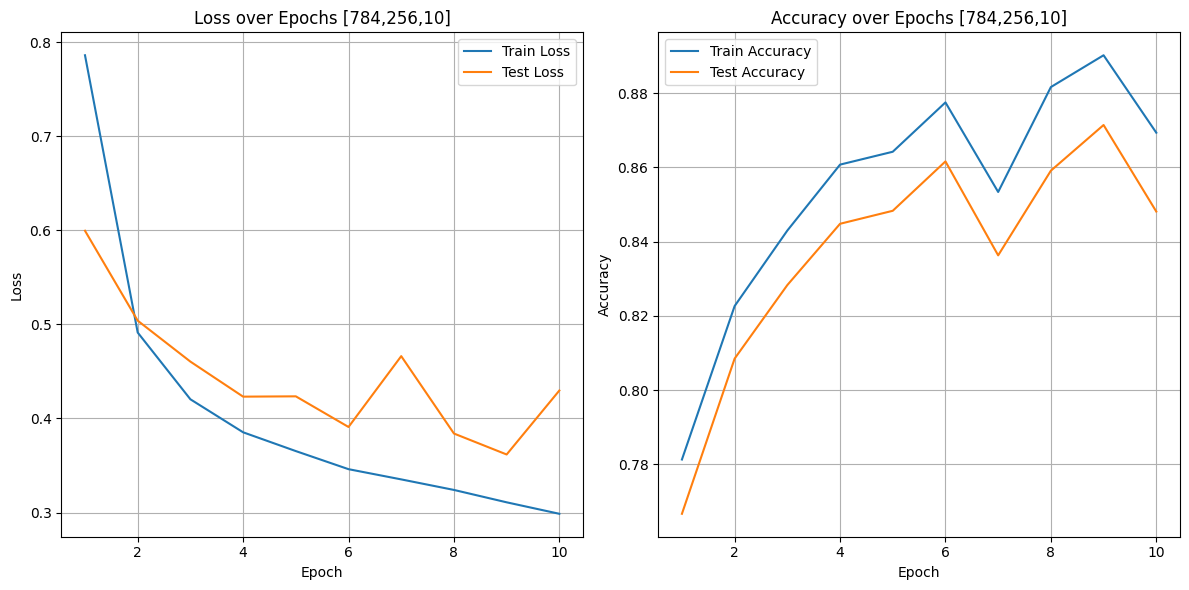

Final Test Accuracy for learning_rate 0.5: 0.8481

Training with learning_rate = 1
Starting training with architecture: [784, 256, 10]
Epoch 1/10: train_loss=1.9181, test_loss=2.1051, train_acc=0.1549, test_acc=0.1558
Epoch 2/10: train_loss=1.8306, test_loss=1.8782, train_acc=0.2286, test_acc=0.2353
Epoch 3/10: train_loss=2.0979, test_loss=2.0357, train_acc=0.1995, test_acc=0.2021
Epoch 4/10: train_loss=2.2084, test_loss=2.3733, train_acc=0.1002, test_acc=0.1005
Epoch 5/10: train_loss=2.1927, test_loss=2.2791, train_acc=0.1001, test_acc=0.0999
Epoch 6/10: train_loss=1.8428, test_loss=1.3322, train_acc=0.4467, test_acc=0.4448
Epoch 7/10: train_loss=1.7620, test_loss=2.2328, train_acc=0.1665, test_acc=0.1656
Epoch 8/10: train_loss=2.0335, test_loss=1.9077, train_acc=0.2335, test_acc=0.2345
Epoch 9/10: train_loss=2.1072, test_loss=2.3913, train_acc=0.1859, test_acc=0.1852
Epoch 10/10: train_loss=2.1613, test_loss=2.0715, train_acc=0.1625, test_acc=0.1615


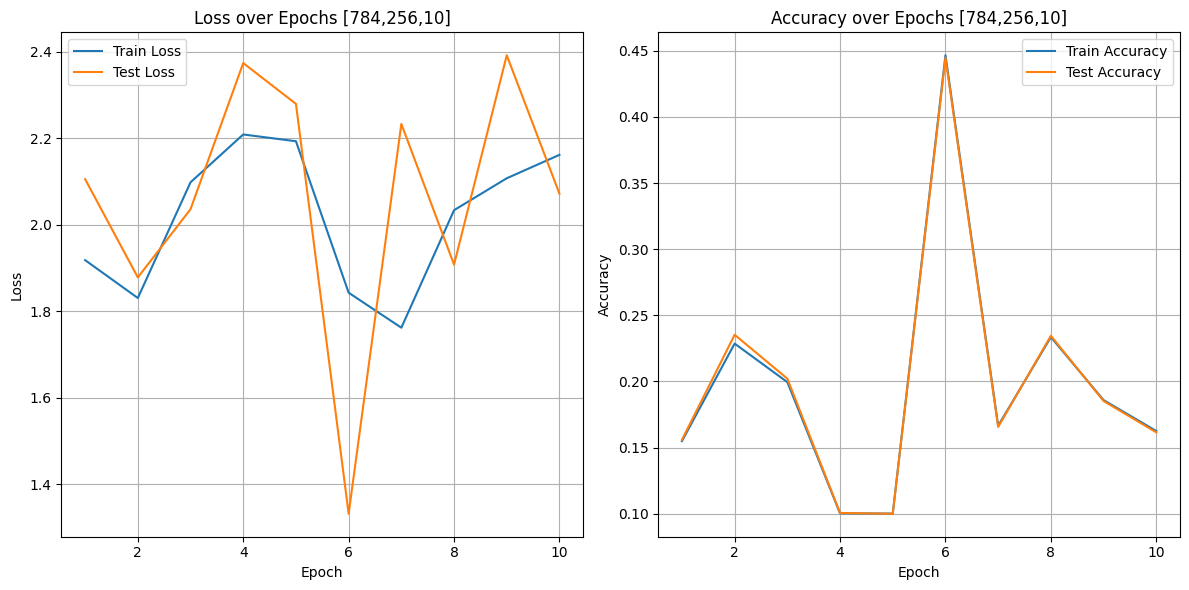

Final Test Accuracy for learning_rate 1: 0.1615
The Best Test Accuracy for learning_rate 0.3: 0.8579


In [ ]:
lrs = [0.001, 0.01, 0.1, 0.3, 0.5, 1]
layer_dimensions  = [784, 256, 10]
num_epochs        = 10

final_test_accuracies = []
best_accuracy = 0.0
best_learning_rate = 0

for learning_rate in lrs:
  print(f"\nTraining with learning_rate = {learning_rate}")
  trained_epochs, t_losses, v_losses, t_accs, v_accs, trained_params = train_model_n_hidden_layers(
          layer_dims=layer_dimensions,
          learning_rate=learning_rate,
          sigma=sigma,
          num_epochs=num_epochs
      )
  layer_dims_for_plot = str(layer_dimensions).replace(" ","")
  show_training_graphs(trained_epochs, t_losses, v_losses, t_accs, v_accs, layer_dims_str=layer_dims_for_plot)
  final_test_accuracies.append(v_accs[-1])
  print(f"Final Test Accuracy for learning_rate {learning_rate}: {v_accs[-1]:.4f}")
  if v_accs[-1] > best_accuracy:
      best_accuracy = v_accs[-1]
      best_learning_rate = learning_rate
print(f"The Best Test Accuracy for learning_rate {best_learning_rate}: {best_accuracy:.4f}")

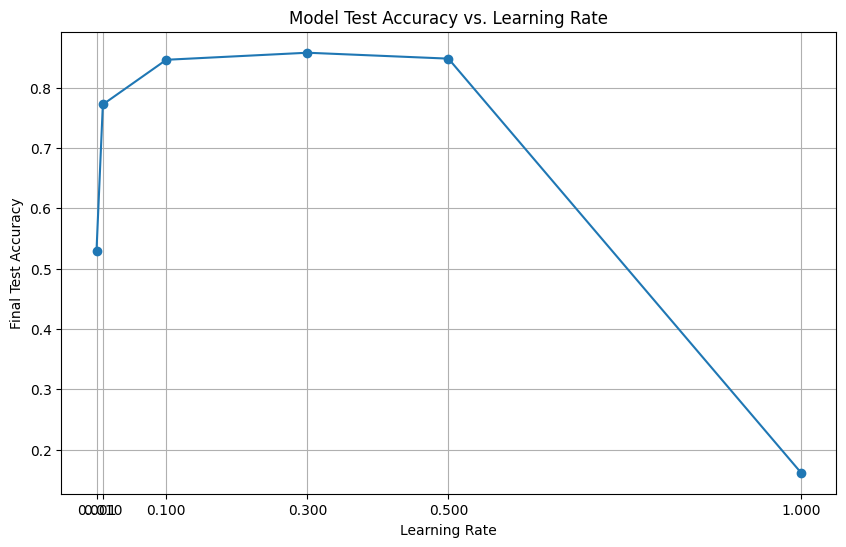

In [ ]:
# Vẽ đồ thị
plt.figure(figsize=(10, 6))
plt.plot(lrs, final_test_accuracies, marker='o', linestyle='-')
plt.title('Model Test Accuracy vs. Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Final Test Accuracy')
plt.xticks(lrs)
plt.grid(True)

*   Khi learning rate thay đổi:
    *   Độ chính xác của mô hình cũng thay đổi. Độ chính xác tăng giai đoạn đầu, sau đó giảm khi độ ổn đinh giảm.
    *   Độ ổn định giảm mạnh khi learning rate tăng cao.

*   Tăng num_epochs lên 20


Training with learning_rate = 0.001
Starting training with architecture: [784, 256, 10]
Epoch 1/20: train_loss=2.2941, test_loss=2.2863, train_acc=0.2777, test_acc=0.2790
Epoch 2/20: train_loss=2.2781, test_loss=2.2690, train_acc=0.3074, test_acc=0.3036
Epoch 3/20: train_loss=2.2584, test_loss=2.2468, train_acc=0.3108, test_acc=0.3113
Epoch 4/20: train_loss=2.2329, test_loss=2.2177, train_acc=0.3016, test_acc=0.2998
Epoch 5/20: train_loss=2.1996, test_loss=2.1802, train_acc=0.3064, test_acc=0.3038
Epoch 6/20: train_loss=2.1573, test_loss=2.1332, train_acc=0.3558, test_acc=0.3509
Epoch 7/20: train_loss=2.1051, test_loss=2.0759, train_acc=0.4181, test_acc=0.4068
Epoch 8/20: train_loss=2.0426, test_loss=2.0088, train_acc=0.4700, test_acc=0.4594
Epoch 9/20: train_loss=1.9708, test_loss=1.9334, train_acc=0.4927, test_acc=0.4855
Epoch 10/20: train_loss=1.8926, test_loss=1.8538, train_acc=0.5084, test_acc=0.5010
Epoch 11/20: train_loss=1.8123, test_loss=1.7743, train_acc=0.5179, test_acc=0.5

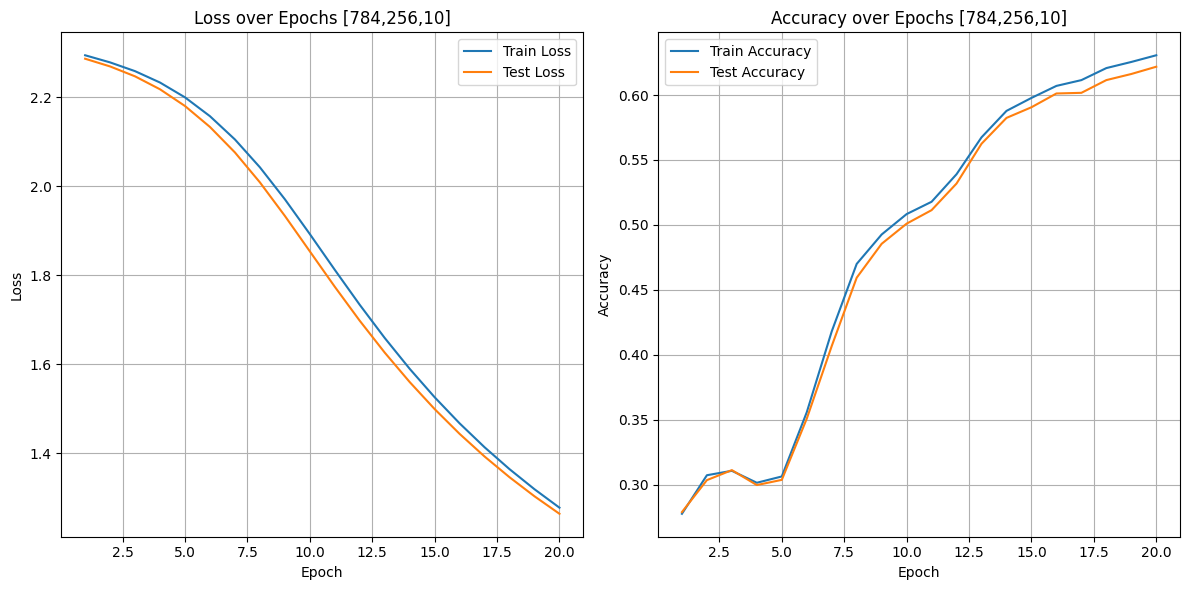

Final Test Accuracy for learning_rate 0.001: 0.6218

Training with learning_rate = 0.01
Starting training with architecture: [784, 256, 10]
Epoch 1/20: train_loss=2.1510, test_loss=1.8567, train_acc=0.5010, test_acc=0.4943
Epoch 2/20: train_loss=1.5108, test_loss=1.2588, train_acc=0.6211, test_acc=0.6139
Epoch 3/20: train_loss=1.1107, test_loss=1.0093, train_acc=0.6562, test_acc=0.6433
Epoch 4/20: train_loss=0.9311, test_loss=0.8873, train_acc=0.6814, test_acc=0.6702
Epoch 5/20: train_loss=0.8370, test_loss=0.8191, train_acc=0.6987, test_acc=0.6851
Epoch 6/20: train_loss=0.7786, test_loss=0.7711, train_acc=0.7211, test_acc=0.7071
Epoch 7/20: train_loss=0.7357, test_loss=0.7357, train_acc=0.7407, test_acc=0.7272
Epoch 8/20: train_loss=0.7013, test_loss=0.7033, train_acc=0.7613, test_acc=0.7498
Epoch 9/20: train_loss=0.6718, test_loss=0.6769, train_acc=0.7712, test_acc=0.7634
Epoch 10/20: train_loss=0.6465, test_loss=0.6546, train_acc=0.7812, test_acc=0.7726
Epoch 11/20: train_loss=0.624

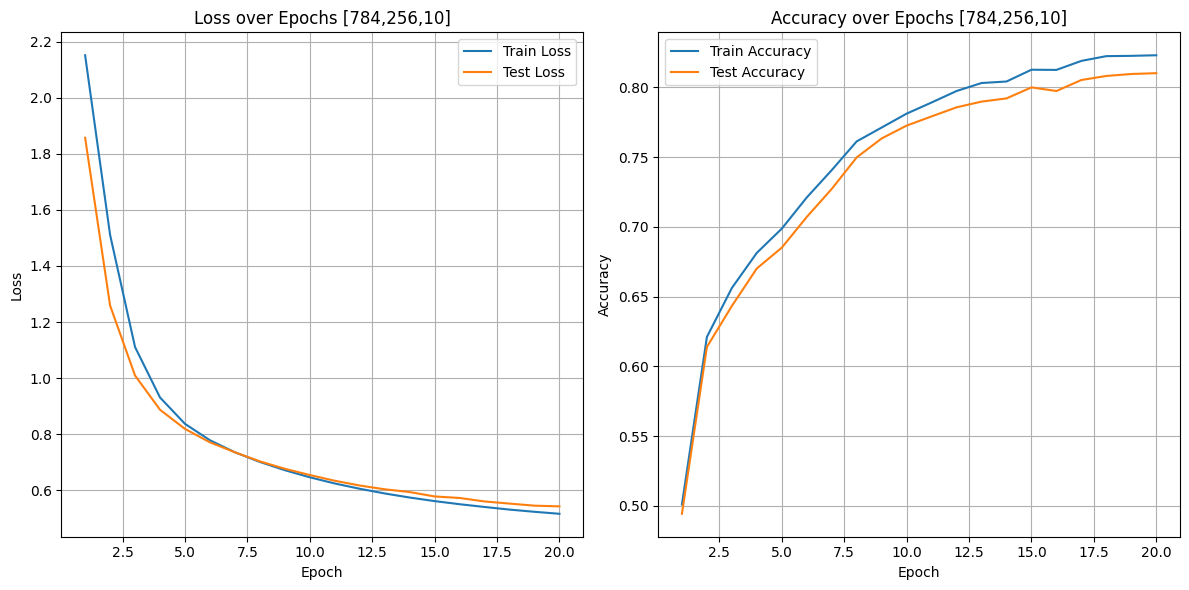

Final Test Accuracy for learning_rate 0.01: 0.8102

Training with learning_rate = 0.1
Starting training with architecture: [784, 256, 10]
Epoch 1/20: train_loss=1.0432, test_loss=0.7034, train_acc=0.7512, test_acc=0.7429
Epoch 2/20: train_loss=0.6024, test_loss=0.6131, train_acc=0.7873, test_acc=0.7748
Epoch 3/20: train_loss=0.5201, test_loss=0.7515, train_acc=0.7528, test_acc=0.7363
Epoch 4/20: train_loss=0.4823, test_loss=0.5276, train_acc=0.8195, test_acc=0.8075
Epoch 5/20: train_loss=0.4532, test_loss=0.5275, train_acc=0.8159, test_acc=0.7979
Epoch 6/20: train_loss=0.4335, test_loss=0.4979, train_acc=0.8367, test_acc=0.8222
Epoch 7/20: train_loss=0.4177, test_loss=0.4517, train_acc=0.8539, test_acc=0.8377
Epoch 8/20: train_loss=0.4041, test_loss=0.4397, train_acc=0.8590, test_acc=0.8433
Epoch 9/20: train_loss=0.3927, test_loss=0.4815, train_acc=0.8364, test_acc=0.8198
Epoch 10/20: train_loss=0.3824, test_loss=0.4308, train_acc=0.8607, test_acc=0.8382
Epoch 11/20: train_loss=0.3741,

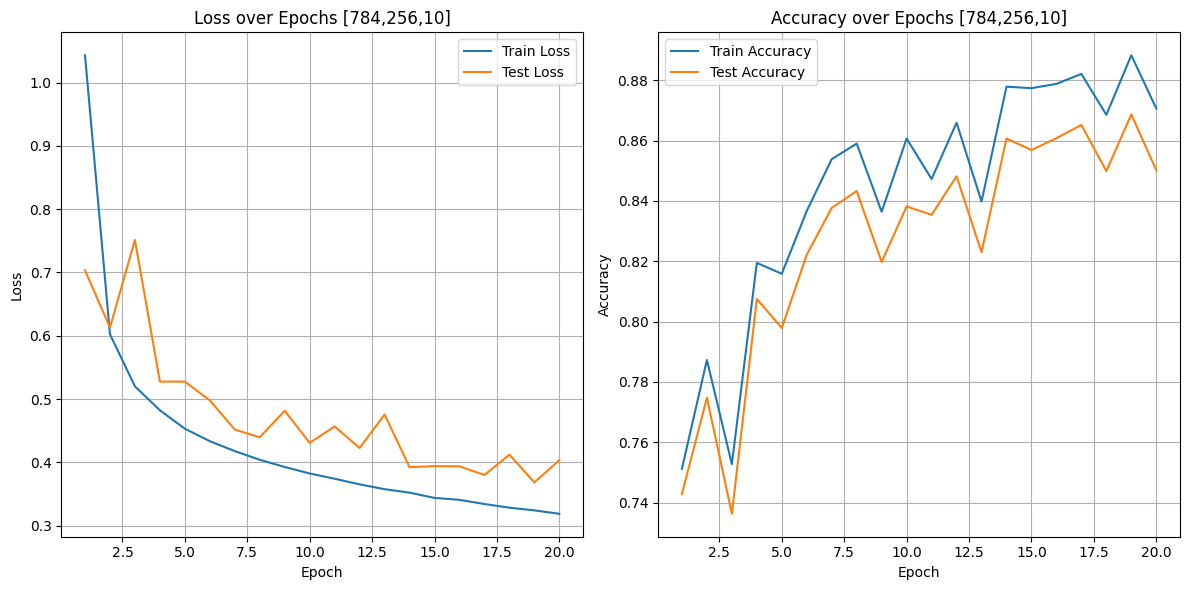

Final Test Accuracy for learning_rate 0.1: 0.8502

Training with learning_rate = 0.3
Starting training with architecture: [784, 256, 10]
Epoch 1/20: train_loss=0.8050, test_loss=0.6549, train_acc=0.7880, test_acc=0.7793
Epoch 2/20: train_loss=0.4965, test_loss=0.5501, train_acc=0.8131, test_acc=0.7986
Epoch 3/20: train_loss=0.4337, test_loss=0.4793, train_acc=0.8400, test_acc=0.8245
Epoch 4/20: train_loss=0.4017, test_loss=0.4206, train_acc=0.8611, test_acc=0.8439
Epoch 5/20: train_loss=0.3780, test_loss=0.4220, train_acc=0.8633, test_acc=0.8479
Epoch 6/20: train_loss=0.3641, test_loss=0.4121, train_acc=0.8646, test_acc=0.8468
Epoch 7/20: train_loss=0.3446, test_loss=0.4426, train_acc=0.8567, test_acc=0.8378
Epoch 8/20: train_loss=0.3399, test_loss=0.3769, train_acc=0.8828, test_acc=0.8666
Epoch 9/20: train_loss=0.3263, test_loss=0.4045, train_acc=0.8727, test_acc=0.8509
Epoch 10/20: train_loss=0.3156, test_loss=0.3913, train_acc=0.8795, test_acc=0.8582
Epoch 11/20: train_loss=0.3105, 

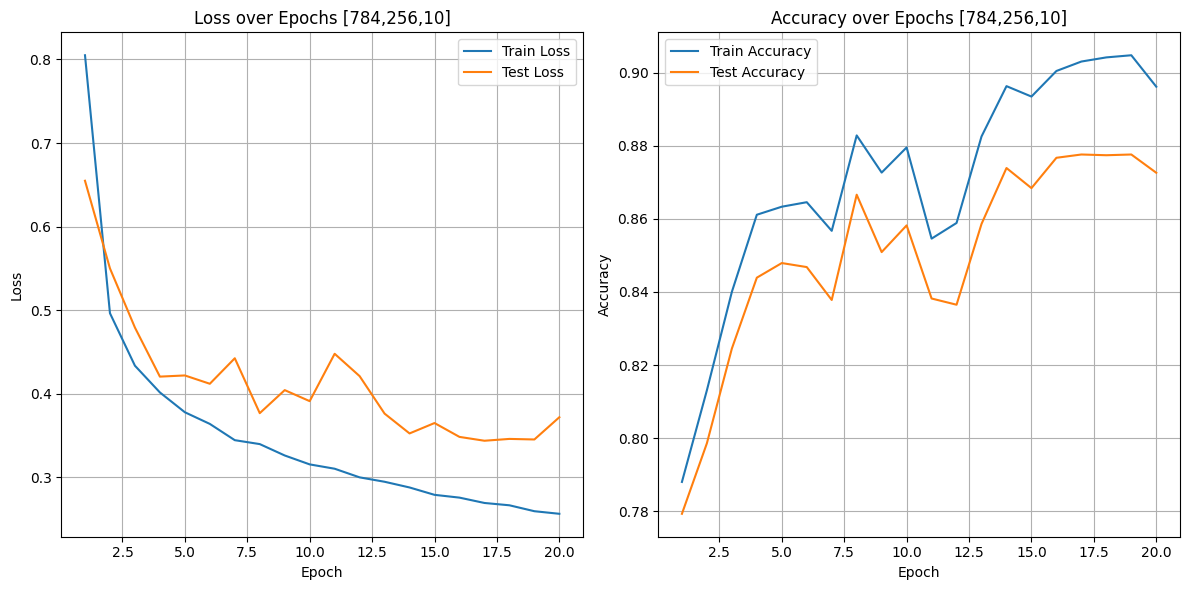

Final Test Accuracy for learning_rate 0.3: 0.8726

Training with learning_rate = 0.5
Starting training with architecture: [784, 256, 10]
Epoch 1/20: train_loss=0.8024, test_loss=0.5761, train_acc=0.7817, test_acc=0.7747
Epoch 2/20: train_loss=0.4847, test_loss=0.5016, train_acc=0.8238, test_acc=0.8100
Epoch 3/20: train_loss=0.4203, test_loss=0.5634, train_acc=0.7995, test_acc=0.7839
Epoch 4/20: train_loss=0.3923, test_loss=0.4008, train_acc=0.8693, test_acc=0.8544
Epoch 5/20: train_loss=0.3673, test_loss=0.4007, train_acc=0.8688, test_acc=0.8482
Epoch 6/20: train_loss=0.3493, test_loss=0.3813, train_acc=0.8784, test_acc=0.8607
Epoch 7/20: train_loss=0.3337, test_loss=0.4469, train_acc=0.8577, test_acc=0.8428
Epoch 8/20: train_loss=0.3230, test_loss=0.3706, train_acc=0.8877, test_acc=0.8685
Epoch 9/20: train_loss=0.3113, test_loss=0.3959, train_acc=0.8811, test_acc=0.8629
Epoch 10/20: train_loss=0.3033, test_loss=0.3793, train_acc=0.8848, test_acc=0.8616
Epoch 11/20: train_loss=0.2923, 

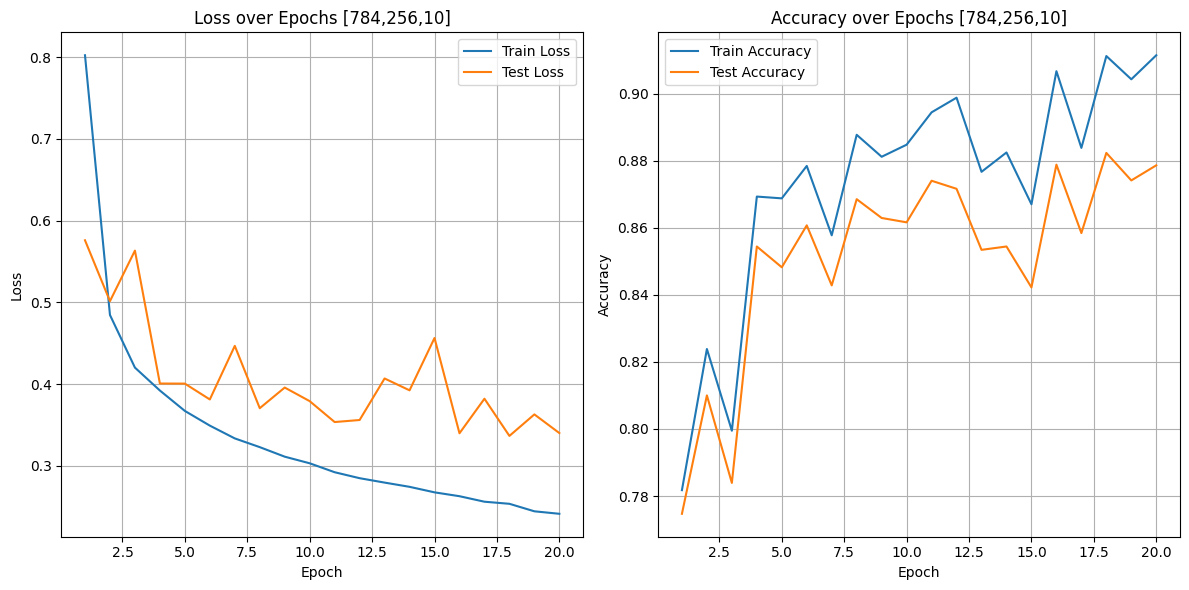

Final Test Accuracy for learning_rate 0.5: 0.8786

Training with learning_rate = 1
Starting training with architecture: [784, 256, 10]
Epoch 1/20: train_loss=2.0050, test_loss=1.4939, train_acc=0.3892, test_acc=0.3907
Epoch 2/20: train_loss=1.6117, test_loss=1.4250, train_acc=0.3465, test_acc=0.3495
Epoch 3/20: train_loss=1.9962, test_loss=1.9594, train_acc=0.2422, test_acc=0.2413
Epoch 4/20: train_loss=1.6324, test_loss=2.2103, train_acc=0.2695, test_acc=0.2654
Epoch 5/20: train_loss=2.0778, test_loss=1.8000, train_acc=0.2641, test_acc=0.2661
Epoch 6/20: train_loss=1.8900, test_loss=2.1217, train_acc=0.1835, test_acc=0.1829
Epoch 7/20: train_loss=1.9544, test_loss=2.4228, train_acc=0.1560, test_acc=0.1553
Epoch 8/20: train_loss=2.1444, test_loss=2.2613, train_acc=0.1293, test_acc=0.1331
Epoch 9/20: train_loss=2.2039, test_loss=2.1903, train_acc=0.1744, test_acc=0.1751
Epoch 10/20: train_loss=2.2100, test_loss=2.3036, train_acc=0.1001, test_acc=0.1001
Epoch 11/20: train_loss=2.2134, te

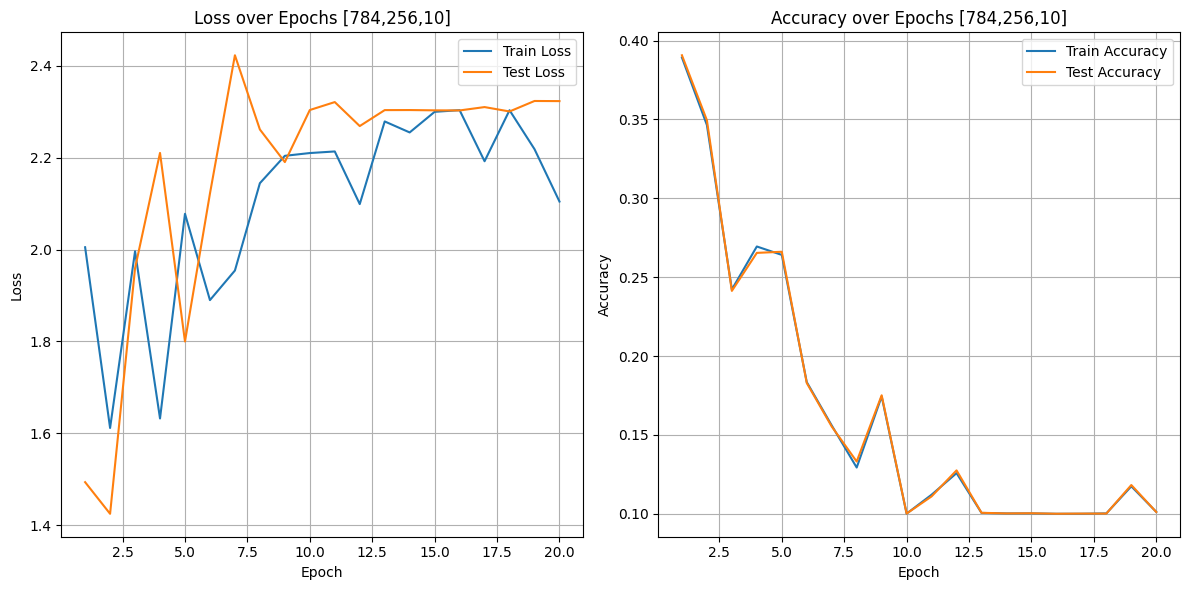

Final Test Accuracy for learning_rate 1: 0.1011
The Best Test Accuracy for learning_rate 0.5: 0.8786


In [ ]:
lrs = [0.001, 0.01, 0.1, 0.3, 0.5, 1]
layer_dimensions  = [784, 256, 10]
num_epochs        = 20

final_test_accuracies = []
best_accuracy = 0.0
best_learning_rate = 0

for learning_rate in lrs:
  print(f"\nTraining with learning_rate = {learning_rate}")
  trained_epochs, t_losses, v_losses, t_accs, v_accs, trained_params = train_model_n_hidden_layers(
          layer_dims=layer_dimensions,
          learning_rate=learning_rate,
          sigma=sigma,
          num_epochs=num_epochs
      )
  layer_dims_for_plot = str(layer_dimensions).replace(" ","")
  show_training_graphs(trained_epochs, t_losses, v_losses, t_accs, v_accs, layer_dims_str=layer_dims_for_plot)
  final_test_accuracies.append(v_accs[-1])
  print(f"Final Test Accuracy for learning_rate {learning_rate}: {v_accs[-1]:.4f}")
  if v_accs[-1] > best_accuracy:
      best_accuracy = v_accs[-1]
      best_learning_rate = learning_rate
print(f"The Best Test Accuracy for learning_rate {best_learning_rate}: {best_accuracy:.4f}")

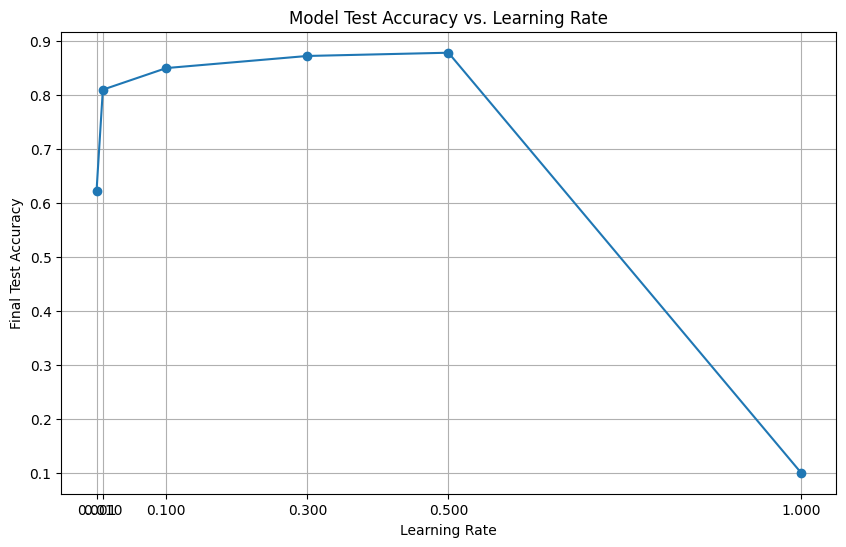

In [ ]:
# Vẽ đồ thị
plt.figure(figsize=(10, 6))
plt.plot(lrs, final_test_accuracies, marker='o', linestyle='-')
plt.title('Model Test Accuracy vs. Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Final Test Accuracy')
plt.xticks(lrs)
plt.grid(True)

*   Khi tăng epoch:
    *   Độ chính xác của mô hình cũng thay đổi. Độ chính xác tăng giai đoạn đầu, sau đó giảm khi độ ổn đinh giảm.
    *   Độ ổn định giảm mạnh hơn khi learning rate tăng cao.

### 5.Let’s optimize over all hyperparameters jointly, i.e., learning rate, number of epochs, number of hidden layers, and number of hidden units per layer.

In [ ]:
!pip install d2l==1.0.3

In [ ]:
# bổ sung import
import time
import random
import torch

from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt
print(f"✅ CUDA available: {torch.cuda.is_available()}")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Đang sử dụng: {device.upper()}")

✅ CUDA available: False
Đang sử dụng: CPU


In [ ]:
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader

# ✅ Viết lại hàm có num_workers
def load_data_fashion_mnist(batch_size, resize=None, num_workers=2):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)

    mnist_train = FashionMNIST(root="./data", train=True, download=True, transform=trans)
    mnist_test = FashionMNIST(root="./data", train=False, download=True, transform=trans)

    return (
        DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers),
        DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    )


Build MLP Function

In [ ]:
def build_mlp(units_per_layer):
    layers = [nn.Flatten()]
    input_dim = 784  # 28x28 ảnh

    for units in units_per_layer:
        layers.append(nn.Linear(input_dim, units))
        layers.append(nn.ReLU())
        input_dim = units

    layers.append(nn.Linear(input_dim, 10))  # output lớp
    return nn.Sequential(*layers).to(device)

In [ ]:
def train_mlp(hidden_units, lr, batch_size, num_epochs):
    net = build_mlp(hidden_units)
    net.apply(lambda m: nn.init.xavier_uniform_(m.weight) if isinstance(m, nn.Linear) else None)

    loss = nn.CrossEntropyLoss()
    trainer = torch.optim.SGD(net.parameters(), lr=lr)

    # ✅ tăng tốc load dữ liệu
    train_iter, test_iter = load_data_fashion_mnist(batch_size, num_workers=2)

    for epoch in range(num_epochs):
        net.train()
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()

    acc = d2l.evaluate_accuracy_gpu(net, test_iter)
    return acc


In [ ]:
# Thông số cần thử
hidden_options = [64, 128, 256, 512]
lr_options = [0.01, 0.05, 0.1]
batch_options = [32, 64, 128]
num_trials = 5
num_epochs = 10

results = []
start_time = time.time()

for i in range(num_trials):
    hidden_units = [random.choice(hidden_options)]
    # thử random thêm tầng thứ 2
    if random.random() < 0.5:
        hidden_units.append(random.choice(hidden_options))

    lr = random.choice(lr_options)
    batch_size = random.choice(batch_options)

    print(f"\n Trial {i+1}/{num_trials} → Hidden: {hidden_units}, LR: {lr}, Batch: {batch_size}")
    t0 = time.time()
    acc = train_mlp(hidden_units, lr, batch_size, num_epochs)
    t1 = time.time()

    print(f" Accuracy: {acc:.4f} | ⏱ Thời gian: {t1 - t0:.2f} giây")
    results.append((acc, hidden_units, lr, batch_size, t1 - t0))

total_time = time.time() - start_time
print(f"\n Tổng thời gian tất cả trials: {total_time:.2f} giây")



 Trial 1/5 → Hidden: [512], LR: 0.1, Batch: 128


100%|██████████| 26.4M/26.4M [00:03<00:00, 8.02MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 138kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.60MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 7.33MB/s]


 Accuracy: 0.8747 | ⏱ Thời gian: 140.81 giây

 Trial 2/5 → Hidden: [512], LR: 0.1, Batch: 64
 Accuracy: 0.8726 | ⏱ Thời gian: 127.31 giây

 Trial 3/5 → Hidden: [512], LR: 0.01, Batch: 32
 Accuracy: 0.8573 | ⏱ Thời gian: 145.79 giây

 Trial 4/5 → Hidden: [256, 256], LR: 0.01, Batch: 32
 Accuracy: 0.8664 | ⏱ Thời gian: 143.11 giây

 Trial 5/5 → Hidden: [128, 256], LR: 0.01, Batch: 128
 Accuracy: 0.8345 | ⏱ Thời gian: 88.78 giây

 Tổng thời gian tất cả trials: 645.81 giây


Vẽ biểu đồ

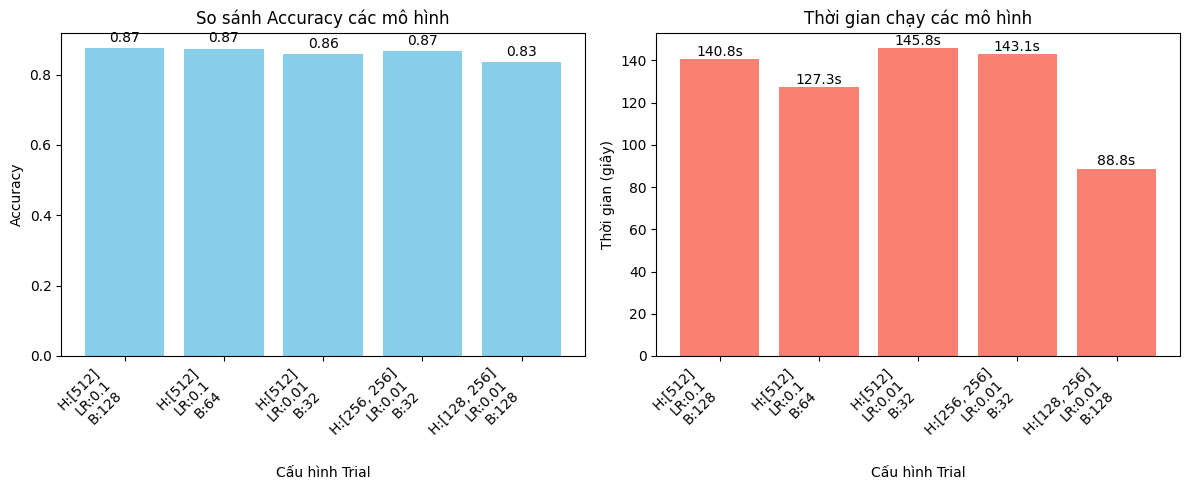

In [ ]:
# Tách dữ liệu từ kết quả
accuracies = [r[0] for r in results]
times = [r[4] for r in results]
labels = [f"H:{r[1]}\nLR:{r[2]}\nB:{r[3]}" for r in results]

# Tạo 2 biểu đồ cạnh nhau
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# === Biểu đồ Accuracy ===
bars1 = axes[0].bar(range(len(results)), accuracies, color='skyblue')
axes[0].set_xticks(range(len(results)))
axes[0].set_xticklabels(labels, rotation=45, ha='right')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Cấu hình Trial')
axes[0].set_title('So sánh Accuracy các mô hình')

# Hiển thị giá trị
for bar, acc in zip(bars1, accuracies):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f"{acc:.2f}", ha='center', va='bottom')

# === Biểu đồ Thời gian ===
bars2 = axes[1].bar(range(len(results)), times, color='salmon')
axes[1].set_xticks(range(len(results)))
axes[1].set_xticklabels(labels, rotation=45, ha='right')
axes[1].set_ylabel('Thời gian (giây)')
axes[1].set_xlabel('Cấu hình Trial')
axes[1].set_title('Thời gian chạy các mô hình')

# Hiển thị giá trị
for bar, t in zip(bars2, times):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f"{t:.1f}s", ha='center', va='bottom')

plt.tight_layout()
plt.show()


1. What is the best result you can get by optimizing over all of them?

In [ ]:
best = max(results, key=lambda x: x[0])
print(f"\n Kết quả tốt nhất: Accuracy = {best[0]:.4f}, Hidden = {best[1]}, LR = {best[2]}, Batch = {best[3]}")


 Kết quả tốt nhất: Accuracy = 0.8747, Hidden = [512], LR = 0.1, Batch = 128


Note: do hạn chế về phần cứng nên chỉ cho epoch = 10 và trial 5 lần

2. Why it is much more challenging to deal with multiple hyperparameters?

Vì không gian tìm kiếm tăng theo cấp số mũ khi có nhiều siêu tham số, các tham số thường có mối quan hệ phức tạp với nhau, và mỗi tổ hợp cần huấn luyện mô hình đầy đủ, rất tốn thời gian và tài nguyên.

3. Describe an efficient strategy for optimizing over multiple parameters jointly.

Sử dụng Bayesian Optimization (ví dụ với Optuna hoặc Hyperopt), vì nó dự đoán tổ hợp siêu tham số tốt tiếp theo dựa trên kết quả các thử nghiệm trước, giúp giảm số lần huấn luyện cần thiết.

In [ ]:
!pip install -q optuna torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 954.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 16.3 MB/s eta 0:00:00


In [ ]:
import optuna

Set Mục tiêu cho Optuna

In [ ]:
def objective(trial):
    # Các siêu tham số sẽ được tối ưu
    lr = trial.suggest_float("lr", 1e-3, 0.2, log=True)
    num_epochs = trial.suggest_int("epochs", 5, 20)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    units_per_layer = [
        trial.suggest_int(f"units_l{i}", 64, 512, step=64)
        for i in range(num_layers)
    ]
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    net = build_mlp(units_per_layer)
    net.apply(lambda m: nn.init.xavier_uniform_(m.weight) if isinstance(m, nn.Linear) else None)

    loss = nn.CrossEntropyLoss()
    trainer = torch.optim.SGD(net.parameters(), lr=lr)
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

    for epoch in range(num_epochs):
        net.train()
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()

    acc = d2l.evaluate_accuracy_gpu(net, test_iter)
    return acc

Dùng Optuna tối ưu

In [ ]:
study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=20)
study.optimize(objective, n_trials=10)
# thử 10 lần, 20 tốn thời gian hơn 30p

print("\n Kết quả tốt nhất:")
print(study.best_trial)

[I 2025-05-09 12:45:12,707] A new study created in memory with name: no-name-3274b682-9c07-4736-a846-9fc6d19c33c5
100%|██████████| 26.4M/26.4M [00:03<00:00, 8.59MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 137kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.52MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 16.7MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
[I 2025-05-09 12:47:00,602] Trial 0 finished with value: 0.8535 and parameters: {'lr': 0.017947943576474123, 'epochs': 9, 'num_layers': 2, 'units_l0': 448, 'units_l1': 128, 'batch_size': 128}. Best is trial 0 with value:


 Kết quả tốt nhất:
FrozenTrial(number=7, state=1, values=[0.894], datetime_start=datetime.datetime(2025, 5, 9, 13, 0, 1, 169352), datetime_complete=datetime.datetime(2025, 5, 9, 13, 5, 24, 269649), params={'lr': 0.07372511423665641, 'epochs': 19, 'num_layers': 2, 'units_l0': 512, 'units_l1': 256, 'batch_size': 32}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lr': FloatDistribution(high=0.2, log=True, low=0.001, step=None), 'epochs': IntDistribution(high=20, log=False, low=5, step=1), 'num_layers': IntDistribution(high=3, log=False, low=1, step=1), 'units_l0': IntDistribution(high=512, log=False, low=64, step=64), 'units_l1': IntDistribution(high=512, log=False, low=64, step=64), 'batch_size': CategoricalDistribution(choices=(32, 64, 128))}, trial_id=7, value=None)


Vẽ biểu đồ

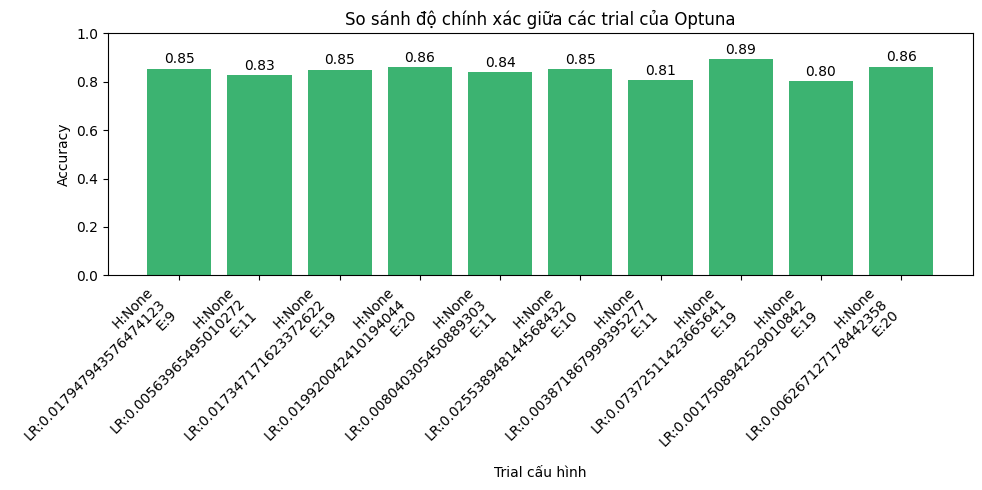

In [ ]:
trials = study.trials
accuracies = [t.value for t in trials]
params = [t.params for t in trials]
labels = [
    f"H:{p.get('num_hidden')}\nLR:{p.get('lr')}\nE:{p.get('epochs')}" for p in params
]

# Vẽ biểu đồ độ chính xác
plt.figure(figsize=(10, 5))
bars = plt.bar(range(len(accuracies)), accuracies, color='mediumseagreen')
plt.xticks(range(len(accuracies)), labels, rotation=45, ha='right')
plt.ylabel("Accuracy")
plt.xlabel("Trial cấu hình")
plt.title("So sánh độ chính xác giữa các trial của Optuna")
plt.ylim(0, 1)

# Ghi giá trị chính xác lên cột
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f"{acc:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

### 6. Compare the speed of the framework and the from-scratch implementation for a challenging problem. How does it change with the complexity of the network?

**So sánh tốc độ: PyTorch (framework) vs. Tự cài (from-scratch)**

Trong phần này, chúng ta sẽ huấn luyện một mạng nơ-ron nhiều tầng trên tập dữ liệu đơn giản  
với 2 cách:
- Dùng PyTorch (framework chuyên dụng, tận dụng GPU)
- Dùng NumPy (tự cài từ đầu, không tối ưu)

Ta sẽ đo thời gian huấn luyện để thấy sự khác biệt khi mạng trở nên phức tạp hơn.


In [ ]:
from torchvision import datasets, transforms
import numpy as np

In [ ]:
class TorchMLP(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[256, 128], output_size=10):
        super().__init__()
        layers = [nn.Flatten()]
        in_dim = input_size
        for h in hidden_sizes:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            in_dim = h
        layers.append(nn.Linear(in_dim, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Load data (just 1 batch for fair comparison)
transform = transforms.ToTensor()
train_dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

X_batch, y_batch = next(iter(train_loader))
X_np = X_batch.view(X_batch.shape[0], -1).numpy()
y_np = y_batch.numpy()

# ----- Benchmark PyTorch -----
torch_model = TorchMLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(torch_model.parameters(), lr=0.1)

start_torch = time.time()
for _ in range(10):  # 10 epochs
    optimizer.zero_grad()
    output = torch_model(X_batch.to(device))
    loss = criterion(output, y_batch.to(device))
    loss.backward()
    optimizer.step()
end_torch = time.time()

print(f" PyTorch training time: {end_torch - start_torch:.4f} seconds")

# ----- From-scratch version (NumPy) -----
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    e = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e / np.sum(e, axis=1, keepdims=True)

def cross_entropy(y_pred, y_true):
    m = y_pred.shape[0]
    p = y_pred[range(m), y_true]
    log_likelihood = -np.log(p + 1e-8)
    return np.sum(log_likelihood) / m

# Init weights
np.random.seed(42)
W1 = np.random.randn(784, 256) * 0.01
b1 = np.zeros((1, 256))
W2 = np.random.randn(256, 128) * 0.01
b2 = np.zeros((1, 128))
W3 = np.random.randn(128, 10) * 0.01
b3 = np.zeros((1, 10))

lr = 0.1
start_numpy = time.time()
for epoch in range(10):
    # Forward
    z1 = X_np @ W1 + b1
    a1 = relu(z1)
    z2 = a1 @ W2 + b2
    a2 = relu(z2)
    z3 = a2 @ W3 + b3
    probs = softmax(z3)

    # Loss
    loss = cross_entropy(probs, y_np)

    # Backward (manual gradient descent)
    m = y_np.shape[0]
    grad_z3 = probs
    grad_z3[range(m), y_np] -= 1
    grad_z3 /= m

    dW3 = a2.T @ grad_z3
    db3 = np.sum(grad_z3, axis=0, keepdims=True)

    da2 = grad_z3 @ W3.T
    dz2 = da2 * (z2 > 0)

    dW2 = a1.T @ dz2
    db2 = np.sum(dz2, axis=0, keepdims=True)

    da1 = dz2 @ W2.T
    dz1 = da1 * (z1 > 0)

    dW1 = X_np.T @ dz1
    db1 = np.sum(dz1, axis=0, keepdims=True)

    # Update
    W1 -= lr * dW1
    b1 -= lr * db1
    W2 -= lr * dW2
    b2 -= lr * db2
    W3 -= lr * dW3
    b3 -= lr * db3
end_numpy = time.time()

print(f"From-scratch (NumPy) training time: {end_numpy - start_numpy:.4f} seconds")

 PyTorch training time: 0.1127 seconds
From-scratch (NumPy) training time: 0.2414 seconds


Càng tăng số tầng ẩn hoặc batch size → khoảng cách càng lớn giữa hai cách tiếp cận.

## 7. Measure the speed of tensor–matrix multiplications for well-aligned and misaligned matrices. For instance, test for matrices with dimension 1024, 1025, 1026, 1028, and 1032.

1.  How does this change between GPUs and CPUs?
2.  Determine the memory bus width of your CPU and GPU.





**Hàm đo thời gian nhân ma trận**

In [ ]:
sizes = [1024, 1025, 1026, 1028, 1032]

# Hàm đo thời gian nhân ma trận
def benchmark_matmul(size, device='cpu', repeat=10):
    A = torch.randn(size, size, device=device)
    B = torch.randn(size, size, device=device)
    # Warm-up
    torch.matmul(A, B)
    torch.cuda.synchronize() if device == 'cuda' else None
    start = time.time()
    for _ in range(repeat):
        torch.matmul(A, B)
    torch.cuda.synchronize() if device == 'cuda' else None
    end = time.time()
    avg_time = (end - start) / repeat
    return avg_time


**Chạy benchmark cho nhiều kích thước**

In [ ]:
devices = ['cpu']
if torch.cuda.is_available():
    devices.append('cuda')

# Ghi kết quả
for device in devices:
    print(f"\n Benchmark trên {device.upper()}")
    for size in sizes:
        t = benchmark_matmul(size, device)
        print(f"Size: {size}x{size} → {t*1000:.2f} ms")



 Benchmark trên CPU
Size: 1024x1024 → 35.40 ms
Size: 1025x1025 → 36.42 ms
Size: 1026x1026 → 34.62 ms
Size: 1028x1028 → 36.99 ms
Size: 1032x1032 → 33.55 ms


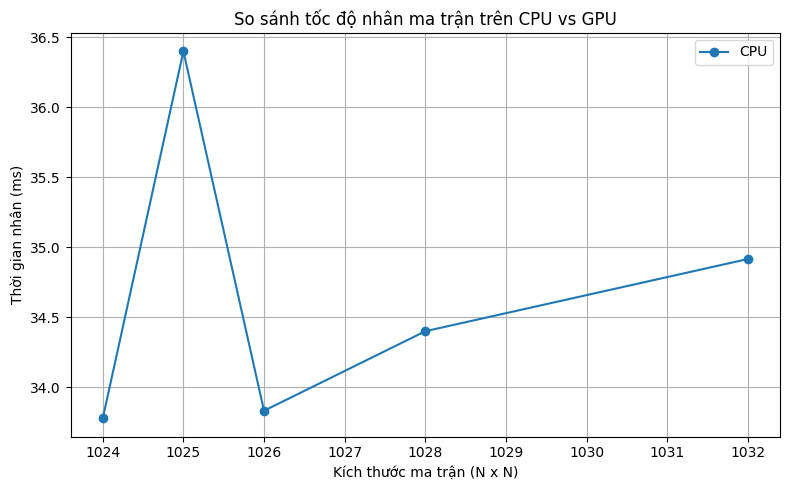

In [ ]:
results = {device: [] for device in devices}

# Đo và lưu kết quả
for device in devices:
    for size in sizes:
        t = benchmark_matmul(size, device)
        results[device].append(t * 1000)  # đổi ra ms

# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
for device in devices:
    plt.plot(sizes, results[device], marker='o', label=f"{device.upper()}")

plt.xlabel("Kích thước ma trận (N x N)")
plt.ylabel("Thời gian nhân (ms)")
plt.title("So sánh tốc độ nhân ma trận trên CPU vs GPU")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Tìm kết quả bench mark (optional)

In [ ]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

### 8. Try out different activation functions. Which one works best?




Tạo 1 data set nhẹ hơn

In [ ]:
# Dataset
transform = transforms.ToTensor()
train_data = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128)

**Định nghĩa mạng MLP với activation linh hoạt**

In [ ]:
class MLP(nn.Module):
    def __init__(self, activation_fn):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.out = nn.Linear(128, 10)
        self.activation = activation_fn

    def forward(self, x):
        x = self.flatten(x)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        return self.out(x)


**train + test**

In [ ]:
def train_and_evaluate(activation_fn, name):
    model = MLP(activation_fn).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train
    model.train()
    for epoch in range(5):
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()

    # Evaluate
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    acc = correct / total
    print(f" {name}: Accuracy = {acc:.4f}")
    return acc


**Chạy tất cả activation functions**

Bao gồm:


*   ReLU

* Sigmoid

* Tanh

* Leaky ReLU

* ELU




In [ ]:
import torch.nn.functional as F
activations = {
    "ReLU": F.relu,
    "Sigmoid": torch.sigmoid,
    "Tanh": torch.tanh,
    "LeakyReLU": F.leaky_relu,
    "ELU": F.elu
}

results = {}
for name, act_fn in activations.items():
    print(f"\n Testing activation: {name}")
    acc = train_and_evaluate(act_fn, name)
    results[name] = acc

# Tổng kết
print("\n Kết quả tổng hợp:")
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")



 Testing activation: ReLU
 ReLU: Accuracy = 0.8701

 Testing activation: Sigmoid
 Sigmoid: Accuracy = 0.8665

 Testing activation: Tanh
 Tanh: Accuracy = 0.8794

 Testing activation: LeakyReLU
 LeakyReLU: Accuracy = 0.8731

 Testing activation: ELU
 ELU: Accuracy = 0.8723

 Kết quả tổng hợp:
ReLU: 0.8701
Sigmoid: 0.8665
Tanh: 0.8794
LeakyReLU: 0.8731
ELU: 0.8723


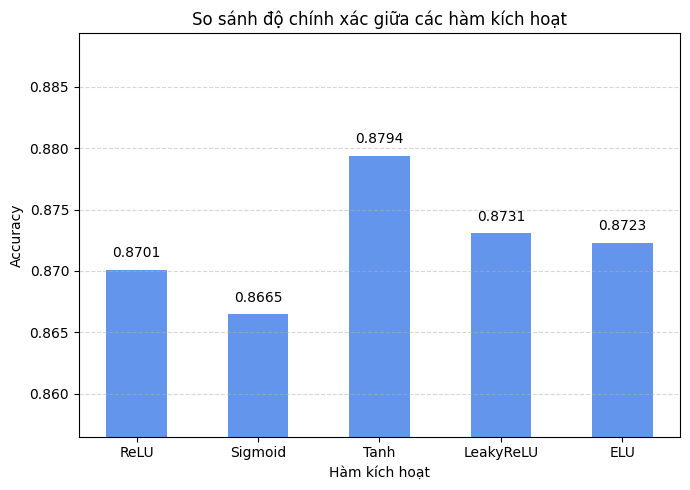

In [ ]:
names = list(results.keys())
accs = list(results.values())

plt.figure(figsize=(7, 5))
bars = plt.bar(names, accs, color='cornflowerblue', width=0.5)

min_acc = min(accs)
max_acc = max(accs)
margin = 0.01
plt.ylim(min_acc - margin, max_acc + margin)

plt.ylabel("Accuracy")
plt.xlabel("Hàm kích hoạt")
plt.title("So sánh độ chính xác giữa các hàm kích hoạt")
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Hiển thị giá trị Accuracy trên đầu mỗi cột
for bar, acc in zip(bars, accs):
    plt.text(bar.get_x() + bar.get_width() / 2, acc + 0.001, f"{acc:.4f}", ha='center')

plt.tight_layout()
plt.show()


Tanh đạt accuracy cao nhất (0.8794), cho thấy hiệu quả tốt nhất trong mô hình này.

LeakyReLU (0.8731), ELU (0.8723) và ReLU (0.8701) có hiệu suất khá tương đồng và cao hơn Sigmoid.

Sigmoid cho kết quả thấp nhất (0.8665), điều này phù hợp vì sigmoid dễ gây vanishing gradient trong mạng sâu.

Kết luận: Tanh hoạt động tốt nhất trong trường hợp này, nhưng các hàm ReLU-based cũng rất cạnh tranh và thường hiệu quả hơn khi mạng phức tạp hơn.

### 9. Is there a difference between weight initializations of the network? Does it matter?

| Phương pháp         | Mô tả ngắn                   | Dùng tốt với         |
| ------------------- | ---------------------------- | -------------------- |
| **Random Normal**   | Trọng số từ phân phối chuẩn  | Cơ bản, dễ bị mất ổn |
| **Xavier (Glorot)** | Cân bằng số chiều đầu vào/ra | `tanh`, `sigmoid`    |
| **Kaiming (He)**    | Dành cho ReLU và biến thể    | `ReLU`, `LeakyReLU`  |
| **Constant/Zero**   | Tệ — không học được gì       |  Không dùng         |



In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )
    def forward(self, x): return self.net(x)

# Hàm khởi tạo
def init_weights(net, method):
    for m in net.modules():
        if isinstance(m, nn.Linear):
            if method == 'xavier':
                nn.init.xavier_uniform_(m.weight)
            elif method == 'he':
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
            elif method == 'random':
                nn.init.normal_(m.weight, mean=0, std=1)

# Train & test nhanh
def train_and_eval(init):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = MLP()
    init_weights(net, init)
    net.to(device)
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        l = loss(net(X), y)
        l.backward()
        optimizer.step()
        break  # chỉ 1 batch
    net.eval()
    X, y = next(iter(test_loader))
    X, y = X.to(device), y.to(device)
    acc = (net(X).argmax(1) == y).float().mean().item()
    return acc


# Thử các phương pháp
results = {}
for method in ['random', 'xavier', 'he']:
    acc = train_and_eval(method)
    results[method] = acc
    print(f"{method} init → acc: {acc:.4f}")

random init → acc: 0.1641
xavier init → acc: 0.2188
he init → acc: 0.2031


Vẽ biểu đồ

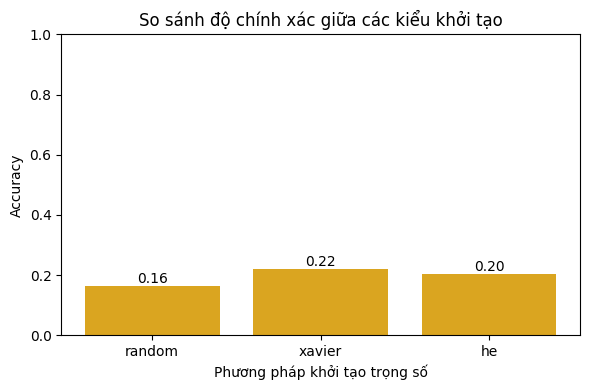

In [ ]:
methods = list(results.keys())
accs = list(results.values())

plt.figure(figsize=(6, 4))
bars = plt.bar(methods, accs, color='goldenrod')
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.xlabel("Phương pháp khởi tạo trọng số")
plt.title("So sánh độ chính xác giữa các kiểu khởi tạo")

# Ghi số lên cột
for bar, acc in zip(bars, accs):
    plt.text(bar.get_x() + bar.get_width() / 2, acc + 0.01, f"{acc:.2f}", ha='center')

plt.tight_layout()
plt.show()


Có sự khác biệt rõ rệt giữa các phương pháp khởi tạo trọng số trong mạng nơ-ron, và điều đó ảnh hưởng rất lớn đến hiệu suất học của mô hình. Việc khởi tạo trọng số là bước đầu tiên trong quá trình huấn luyện mạng, quyết định cách dữ liệu và gradient lan truyền trong mạng.

Nếu khởi tạo không phù hợp, ví dụ như tất cả trọng số bằng 0 hoặc lấy ngẫu nhiên không kiểm soát, mô hình dễ gặp các vấn đề như mất gradient (vanishing gradients) hoặc gradient bùng nổ (exploding gradients), dẫn đến huấn luyện chậm hoặc không hội tụ.

Ngược lại, các phương pháp khởi tạo như Xavier (Glorot) hoặc He (Kaiming) được thiết kế dựa trên đặc tính toán học của mạng để giúp tín hiệu lan truyền ổn định hơn trong quá trình huấn luyện. Cụ thể:

Xavier phù hợp với activation như tanh hoặc sigmoid

He phù hợp với ReLU và các biến thể của nó

Vì vậy, khởi tạo trọng số đúng cách không chỉ giúp mô hình học nhanh hơn mà còn cải thiện độ chính xác và độ ổn định khi huấn luyện.